In [155]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import pandas as pd
import sklearn
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [156]:
# Read dataset
df = pd.read_csv("Seed_dataset_v1.csv")
df.head()

,area,perimeter,compactness,lengthOfKernel,widthOfKernel,asymmetryCoefficient,lengthOfKernelGroove,seedType
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,Kama
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,Kama
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,Kama
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,Kama
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,Kama


# Helper functions

I write some functions to calculate Interquantile Range (IQR) to detect outliers. The second function will be replace outliers by the median based on record's seedType.

In [157]:
def detect_outliers_iqr(df, attribute_name, lower_bound_factor=1.5, upper_bound_factor=1.5):
    """
    Detects outliers using the Interquartile Range (IQR) method.
    Note: 1.5 is a common value in practice.

    Parameters:
        df (DataFrame): The input DataFrame.
        attribute_name (str): The name of the attribute for which to detect outliers.
        lower_bound_factor (float): Multiplier for calculating the lower outlier bound.
        upper_bound_factor (float): Multiplier for calculating the upper outlier bound.
    
    Returns:
        outliers (Series): A boolean Series indicating whether each data point is an outlier.
    """
    attribute_data = df[attribute_name]
    q1 = attribute_data.quantile(0.25)
    q3 = attribute_data.quantile(0.75)
    iqr = q3 - q1
    
    lower_bound = q1 - lower_bound_factor * iqr
    upper_bound = q3 + upper_bound_factor * iqr
    
    outliers = (attribute_data < lower_bound) | (attribute_data > upper_bound)
    
    return outliers

In [158]:
def replace_outliers_with_seed_type_median(df, attribute_name, lower_bound_factor=1.5, upper_bound_factor=1.5):
    """
    Detects outliers using the Interquartile Range (IQR) method and replaces them with seedType median.
    Note: 1.5 is a common value in practice.
    
    Parameters:
        df (DataFrame): The input DataFrame.
        attribute_name (str): The name of the attribute for which to detect outliers.
        lower_bound_factor (float): Multiplier for calculating the lower outlier bound.
        upper_bound_factor (float): Multiplier for calculating the upper outlier bound.
    
    Returns:
        None. The function modifies the input DataFrame in-place.
    """
    attribute_data = df[attribute_name]
    q1 = attribute_data.quantile(0.25)
    q3 = attribute_data.quantile(0.75)
    iqr = q3 - q1
    
    lower_bound = q1 - lower_bound_factor * iqr
    upper_bound = q3 + upper_bound_factor * iqr
    
    for seed_type in df['seedType'].unique():
        seed_type_median = df[df['seedType'] == seed_type][attribute_name].median()
        mask = (df['seedType'] == seed_type) & ((attribute_data < lower_bound) | (attribute_data > upper_bound))
        df.loc[mask, attribute_name] = seed_type_median

In [159]:
def replace_null_with_seed_type_median(df, attribute_name):
    """
    Replaces null values with the seedType median for the specified attribute.
    
    Parameters:
        df (DataFrame): The input DataFrame.
        attribute_name (str): The name of the attribute for which to replace null values.
    
    Returns:
        None.
    """
    for seed_type in df['seedType'].unique():
        seed_type_median = df[df['seedType'] == seed_type][attribute_name].median()
        mask = (df['seedType'] == seed_type) & df[attribute_name].isnull()
        df.loc[mask, attribute_name] = seed_type_median


# Genneral things (Task 4 before preprocessing)

In [160]:
# The data has 210 rows and 8 columns
df.shape

(210, 8)

In [161]:
df.describe()

,area,perimeter,compactness,lengthOfKernel,widthOfKernel,asymmetryCoefficient,lengthOfKernelGroove
count,209.000000,209.000000,203.000000,209.000000,209.000000,208.000000,202.000000
mean,14.865072,14.568804,0.871068,5.631632,3.260751,3.693357,5.409213
std,2.905525,1.301772,0.023773,0.441841,0.377335,1.508749,0.496226
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000
25%,12.300000,13.450000,0.856550,5.263000,2.953000,2.540750,5.044250
50%,14.370000,14.350000,0.873400,5.527000,3.242000,3.597500,5.221500
75%,17.320000,15.730000,0.888000,5.980000,3.562000,4.773250,5.878500
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.456000,6.550000


In [162]:
# Check the type and non-null count of each feature
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   area                  209 non-null    float64
 1   perimeter             209 non-null    float64
 2   compactness           203 non-null    float64
 3   lengthOfKernel        209 non-null    float64
 4   widthOfKernel         209 non-null    float64
 5   asymmetryCoefficient  208 non-null    float64
 6   lengthOfKernelGroove  202 non-null    float64
 7   seedType              210 non-null    object 
dtypes: float64(7), object(1)
memory usage: 13.3+ KB


In [163]:
# Count the number of null values in each feature
df.isnull().sum()

area                    1
perimeter               1
compactness             7
lengthOfKernel          1
widthOfKernel           1
asymmetryCoefficient    2
lengthOfKernelGroove    8
seedType                0
dtype: int64

Most of the features' type are in float64 and there're some null values in some tuples

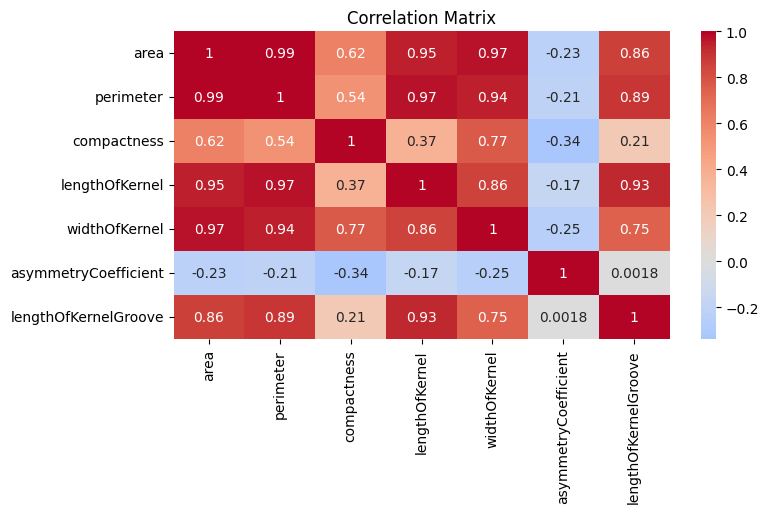

In [164]:
# Plot correlation matrix
plt.figure(figsize=(8, 4))
correlation_matrix = df.loc[:, df.columns != 'seedType'].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()


In [165]:
df.loc[:, df.columns != 'seedType'].corr()

,area,perimeter,compactness,lengthOfKernel,widthOfKernel,asymmetryCoefficient,lengthOfKernelGroove
area,1.000000,0.994331,0.615412,0.949108,0.970571,-0.225591,0.862507
perimeter,0.994331,1.000000,0.535150,0.972133,0.944326,-0.213017,0.890535
compactness,0.615412,0.535150,1.000000,0.370435,0.767829,-0.340170,0.213469
lengthOfKernel,0.949108,0.972133,0.370435,1.000000,0.858408,-0.166831,0.934038
widthOfKernel,0.970571,0.944326,0.767829,0.858408,1.000000,-0.254748,0.745433
asymmetryCoefficient,-0.225591,-0.213017,-0.340170,-0.166831,-0.254748,1.000000,0.001780
lengthOfKernelGroove,0.862507,0.890535,0.213469,0.934038,0.745433,0.001780,1.000000


"area", "perimeter", "lengthOfKernel" and "widthOfKernel" have strong correlation. Let's look at the value in the first row and second column: 0.994331. This value represents the correlation between the "area" variable and the "perimeter" variable. The value is close to 1, indicating a strong positive linear relationship between these two variables. This means that as the "area" increases, the "perimeter" tends to increase as well.

$$
r=\frac{\sum\left(x_{i}-{\bar{x}}\right)\left(y_{i}-{\bar{y}}\right)}{\sqrt{\sum\left(x_{i}-{\bar{x}}\right)^{2}\sum\left(y_{i}-{\bar{y}}\right)^{2}}} 
$$
 ${r}$ correlation coefficient

 ${\mathcal{x}}_{i}$ e values of the x-variable in a sample

 $\overline{{x}}$  mean of the values of the x-variable
 
 ${\mathcal{y}}_{i}$  values of the y-variable in a sample

 $\overline{{y}}$ mean of the values of the y-variable



## Correlation matrix according each seedType

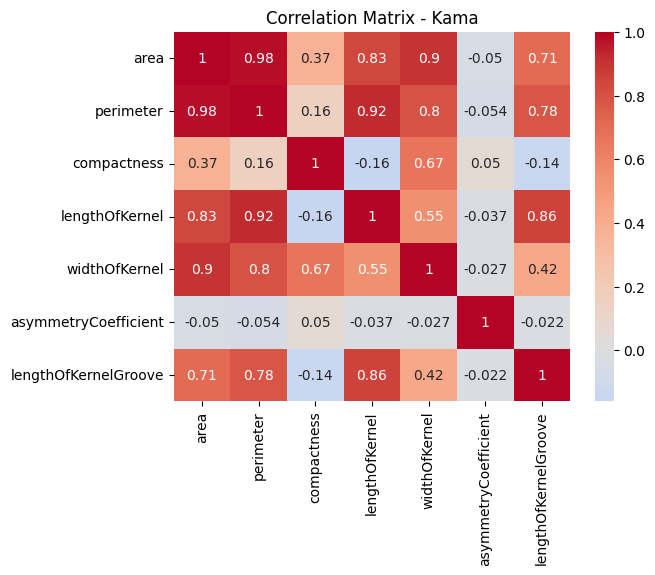

In [166]:
sns.heatmap(df[df['seedType'] == 'Kama'].loc[:, df.columns != 'seedType'].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix - Kama')
plt.show()

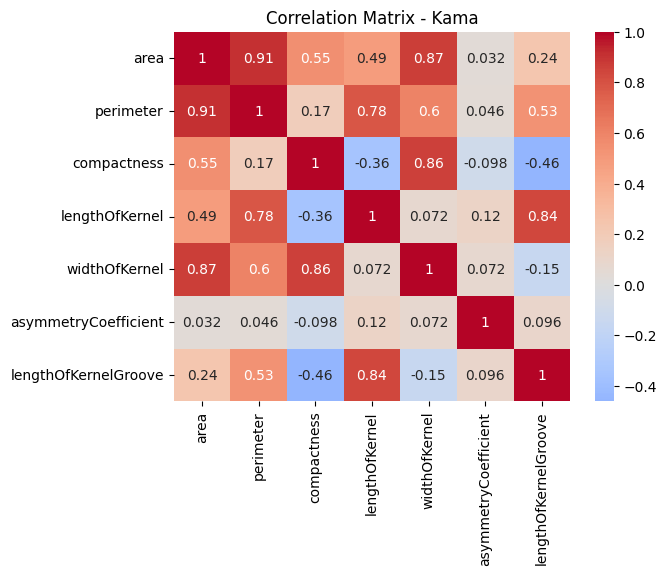

In [167]:
sns.heatmap(df[df['seedType'] == 'Canadian'].loc[:, df.columns != 'seedType'].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix - Kama')
plt.show()

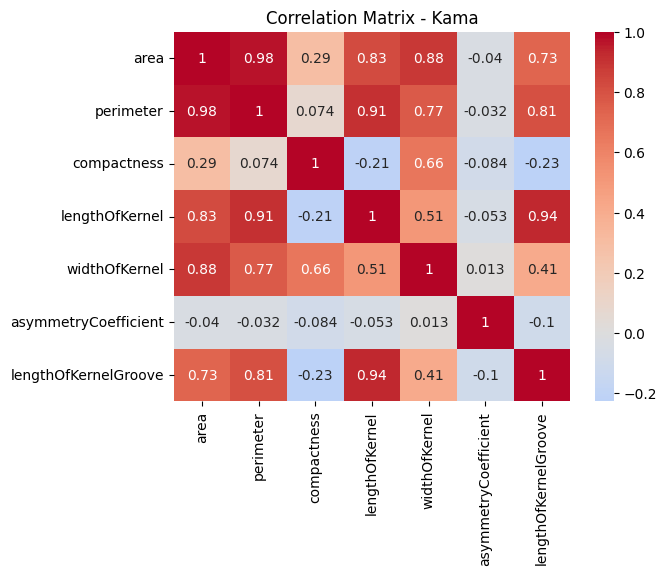

In [168]:
sns.heatmap(df[df['seedType'] == 'Rosa'].loc[:, df.columns != 'seedType'].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix - Kama')
plt.show()

## Boxplots

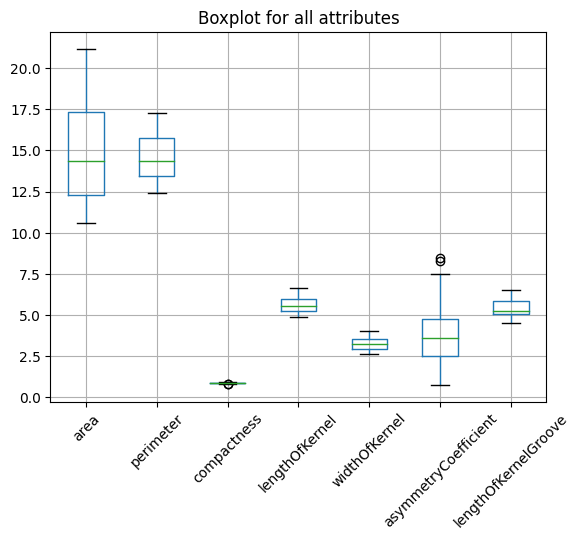

In [169]:
plt.title("Boxplot for all attributes")
df.boxplot()
plt.xticks(rotation= 45)
plt.show()

Overall, compactness and asymmetryCoefficient have outliers, we will go into detail later.

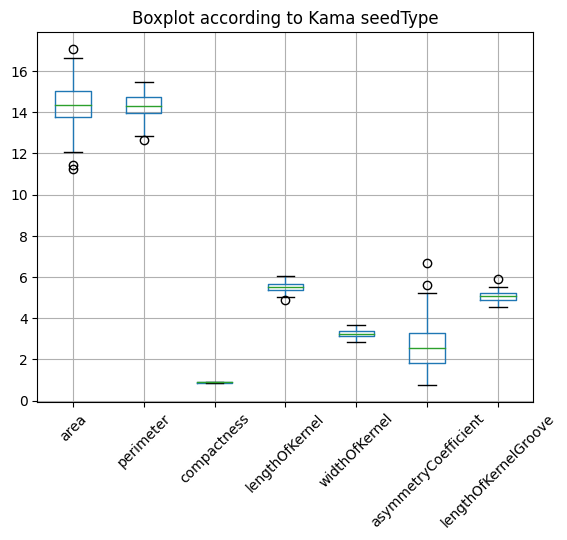

In [170]:
plt.title("Boxplot according to Kama seedType")
df[df['seedType'] == 'Kama'].boxplot()
plt.xticks(rotation= 45)
plt.show()

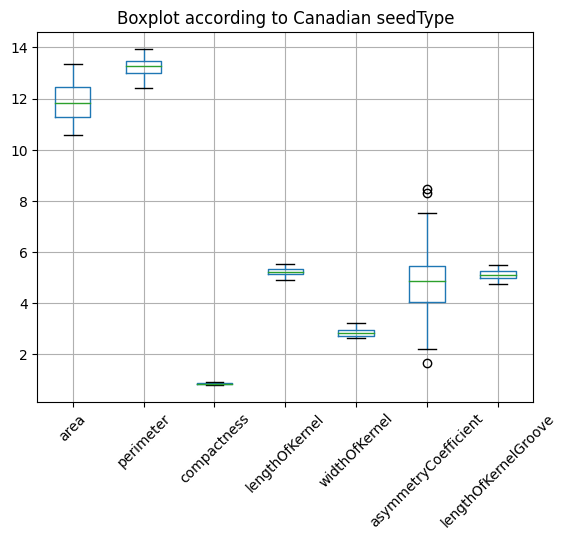

In [171]:
plt.title("Boxplot according to Canadian seedType")
df[df['seedType'] == 'Canadian'].boxplot()
plt.xticks(rotation= 45)
plt.show()

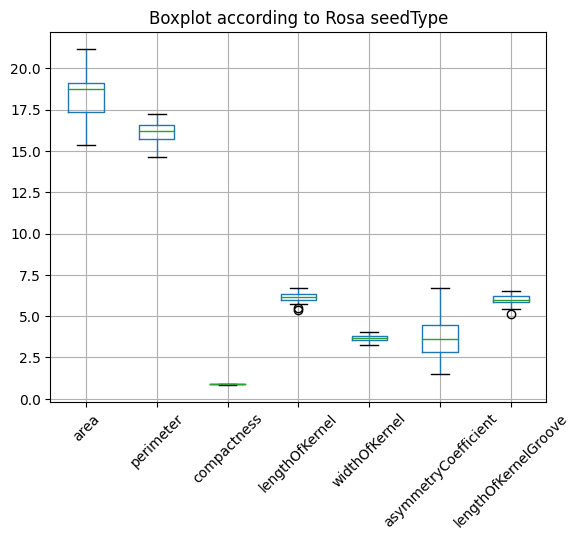

In [172]:
plt.title("Boxplot according to Rosa seedType")
df[df['seedType'] == 'Rosa'].boxplot()
plt.xticks(rotation= 45)
plt.show()

# Part 1: task 1 + 2 + 3

## Show the records having null values

In [173]:
# Count the number of null values in each feature
df.isnull().sum()

area                    1
perimeter               1
compactness             7
lengthOfKernel          1
widthOfKernel           1
asymmetryCoefficient    2
lengthOfKernelGroove    8
seedType                0
dtype: int64

In [174]:
df[df['area'].isna()]

,area,perimeter,compactness,lengthOfKernel,widthOfKernel,asymmetryCoefficient,lengthOfKernelGroove,seedType
202,NaN,12.72,NaN,5.009,NaN,NaN,NaN,Canadian


In [175]:
df[df['perimeter'].isna()]

,area,perimeter,compactness,lengthOfKernel,widthOfKernel,asymmetryCoefficient,lengthOfKernelGroove,seedType
175,10.8,NaN,0.859,NaN,2.821,NaN,NaN,Canadian


In [176]:
df[df['compactness'].isna()]

,area,perimeter,compactness,lengthOfKernel,widthOfKernel,asymmetryCoefficient,lengthOfKernelGroove,seedType
19,12.72,13.57,NaN,5.226,3.049,4.102,4.914,Kama
34,15.05,14.68,NaN,5.712,3.328,2.129,5.360,Kama
90,20.10,16.99,NaN,6.581,3.785,1.955,6.449,Rosa
119,20.03,16.90,NaN,6.493,3.857,3.063,6.320,Rosa
155,11.19,13.05,NaN,5.250,2.675,5.813,5.219,Canadian
202,NaN,12.72,NaN,5.009,NaN,NaN,NaN,Canadian
203,12.70,13.41,NaN,5.183,3.091,8.456,5.000,Canadian


In [177]:
df[df['lengthOfKernel'].isna()]

,area,perimeter,compactness,lengthOfKernel,widthOfKernel,asymmetryCoefficient,lengthOfKernelGroove,seedType
175,10.8,NaN,0.859,NaN,2.821,NaN,NaN,Canadian


In [178]:
df[df['widthOfKernel'].isna()]

,area,perimeter,compactness,lengthOfKernel,widthOfKernel,asymmetryCoefficient,lengthOfKernelGroove,seedType
202,NaN,12.72,NaN,5.009,NaN,NaN,NaN,Canadian


In [179]:
df[df['asymmetryCoefficient'].isna()]

,area,perimeter,compactness,lengthOfKernel,widthOfKernel,asymmetryCoefficient,lengthOfKernelGroove,seedType
175,10.8,NaN,0.859,NaN,2.821,NaN,NaN,Canadian
202,NaN,12.72,NaN,5.009,NaN,NaN,NaN,Canadian


In [180]:
df[df['lengthOfKernelGroove'].isna()]

,area,perimeter,compactness,lengthOfKernel,widthOfKernel,asymmetryCoefficient,lengthOfKernelGroove,seedType
32,14.09,14.41,0.8529,5.717,3.186,3.920,NaN,Kama
35,16.12,15.00,0.9000,5.709,3.485,2.270,NaN,Kama
36,16.20,15.27,0.8734,5.826,3.464,2.823,NaN,Kama
101,17.99,15.86,0.8992,5.890,3.694,2.068,NaN,Rosa
123,18.43,15.97,0.9077,5.980,3.771,2.984,NaN,Rosa
168,11.35,13.12,0.8291,5.176,2.668,4.337,NaN,Canadian
175,10.80,NaN,0.8590,NaN,2.821,NaN,NaN,Canadian
202,NaN,12.72,NaN,5.009,NaN,NaN,NaN,Canadian


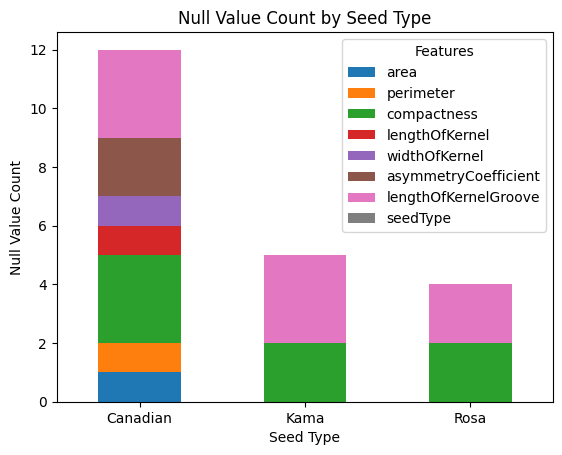

The seedType with the most null values: Canadian


In [181]:
# Calculate null value percentages for each seedType
null_count = df.groupby('seedType').apply(lambda x: x.isnull().sum())

# Find the seedType with the highest null value percentage
seed_type_with_most_null = null_count.mean(axis=1).idxmax()

# Create a bar plot
null_count.plot(kind='bar', stacked=True)
plt.xlabel('Seed Type')
plt.ylabel('Null Value Count')
plt.title('Null Value Count by Seed Type')
plt.legend(title='Features')
plt.xticks(rotation=0)
plt.show()

print(f"The seedType with the most null values: {seed_type_with_most_null}")

We gonna go into detail how to handle these null values in the next sections. I'm trying to impute "appropriate" values intead of deleting the records that may affect to the seedType distribution (becomes not uniform distributed)

## "seedType" analysis

seedType
Kama        70
Rosa        70
Canadian    70
Name: count, dtype: int64


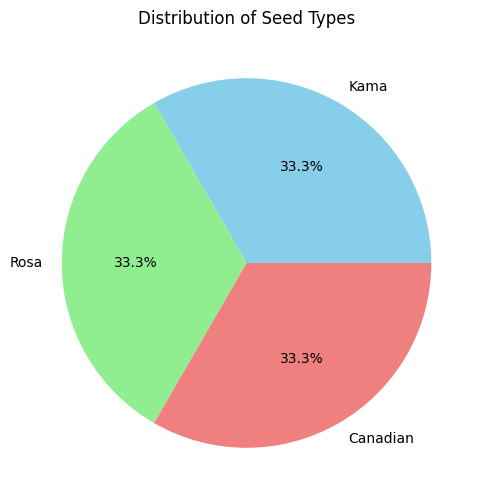

In [182]:
seed_type_counts = df['seedType'].value_counts()
print(seed_type_counts)
# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(seed_type_counts, labels=seed_type_counts.index, autopct='%1.1f%%', colors=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Distribution of Seed Types')
plt.show()

We can see that 3 types of seed have the same population. In the following steps, I will do the bivariate analysis between seedType and other attributes.

In [183]:
df[df['seedType'] == 'Canadian'].describe()

,area,perimeter,compactness,lengthOfKernel,widthOfKernel,asymmetryCoefficient,lengthOfKernelGroove
count,69.000000,69.000000,67.000000,69.000000,69.000000,68.000000,67.000000
mean,11.883913,13.257681,0.848924,5.233116,2.854406,4.799471,5.121269
std,0.723353,0.332535,0.021421,0.135672,0.148501,1.353223,0.161644
min,10.590000,12.410000,0.808100,4.899000,2.630000,1.661000,4.745000
25%,11.270000,13.010000,0.834500,5.137000,2.719000,4.032250,5.002000
50%,11.840000,13.270000,0.849100,5.224000,2.836000,4.855000,5.092000
75%,12.440000,13.470000,0.861100,5.325000,2.967000,5.469750,5.247000
max,13.370000,13.950000,0.897700,5.541000,3.232000,8.456000,5.491000


In [184]:
df[df['seedType'] == 'Kama'].describe()

,area,perimeter,compactness,lengthOfKernel,widthOfKernel,asymmetryCoefficient,lengthOfKernelGroove
count,70.000000,70.000000,68.000000,70.000000,70.000000,70.000000,67.000000
mean,14.334429,14.294286,0.880271,5.508057,3.244629,2.667403,5.072179
std,1.215704,0.576583,0.016368,0.231508,0.177616,1.173901,0.258728
min,11.230000,12.630000,0.839200,4.902000,2.850000,0.765100,4.519000
25%,13.750000,13.960000,0.869275,5.384500,3.134250,1.826500,4.893000
50%,14.355000,14.320000,0.881450,5.534000,3.243500,2.545500,5.088000
75%,15.045000,14.732500,0.891400,5.677000,3.378500,3.301000,5.219500
max,17.080000,15.460000,0.918300,6.053000,3.683000,6.685000,5.877000


In [185]:
df[df['seedType'] == 'Rosa'].describe()

,area,perimeter,compactness,lengthOfKernel,widthOfKernel,asymmetryCoefficient,lengthOfKernelGroove
count,70.000000,70.000000,68.000000,70.000000,70.000000,70.000000,68.000000
mean,18.334286,16.135714,0.883684,6.148029,3.677414,3.644800,6.025000
std,1.439496,0.616995,0.015688,0.268191,0.185539,1.181868,0.256291
min,15.380000,14.660000,0.845200,5.363000,3.231000,1.472000,5.144000
25%,17.330000,15.737500,0.872075,5.979250,3.554250,2.845500,5.878500
50%,18.720000,16.210000,0.883950,6.148500,3.693500,3.609500,6.000500
75%,19.137500,16.557500,0.898425,6.312000,3.804750,4.436000,6.190250
max,21.180000,17.250000,0.910800,6.675000,4.033000,6.682000,6.550000


## 'Area' and 'Perimeter' analysis

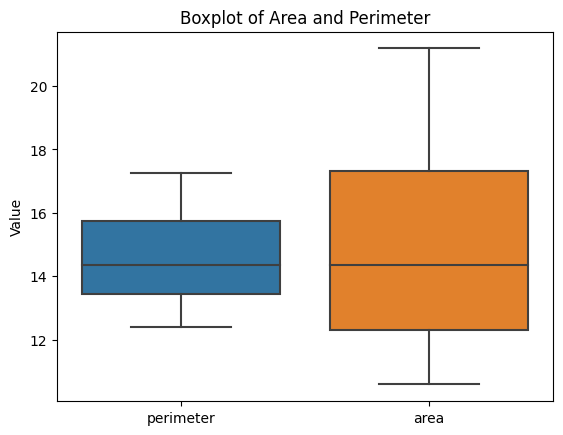

In [186]:
# Create a boxplot using seaborn
sns.boxplot(data=df[["perimeter", "area"]])
plt.title('Boxplot of Area and Perimeter')
plt.ylabel('Value')
plt.show()

There's no outlier in 2 distributions.

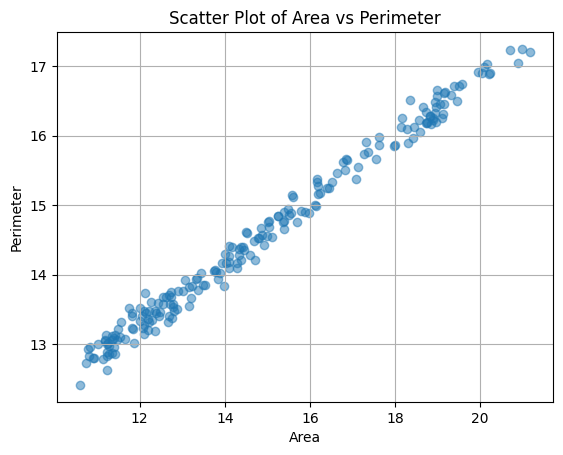

In [187]:
plt.scatter(df['area'], df['perimeter'], alpha=0.5)
plt.title('Scatter Plot of Area vs Perimeter')
plt.xlabel('Area')
plt.ylabel('Perimeter')
plt.grid(True)
plt.show()

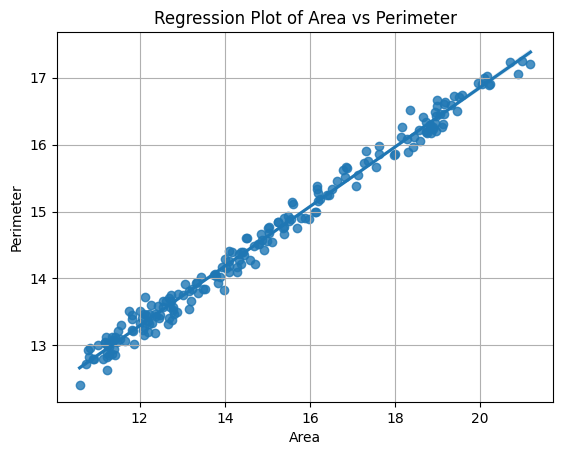

In [188]:
plt.title('Regression Plot of Area vs Perimeter')
sns.regplot(x ='area', y ='perimeter', data = df)
plt.xlabel('Area')
plt.ylabel('Perimeter')
plt.grid(True)
plt.show()

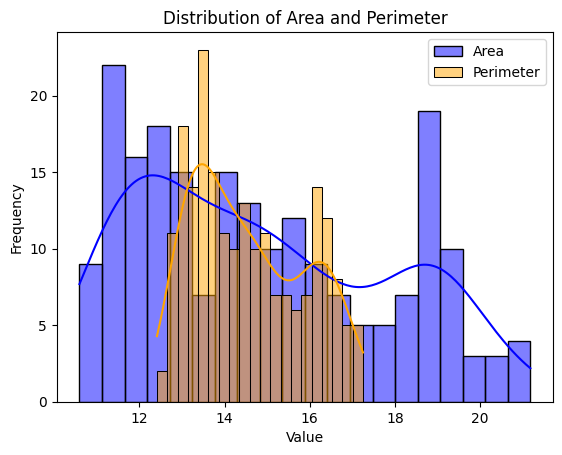

In [189]:
# Plot distributions
sns.histplot(data=df.loc[:, df.columns != 'seedType'], x='area', kde=True, bins=20, color='blue', label='Area')
sns.histplot(data=df.loc[:, df.columns != 'seedType'], x='perimeter', kde=True, bins=20, color='orange', label='Perimeter')
plt.title('Distribution of Area and Perimeter')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

I'm going to apply linear regression to make prediction for null value of perimeter based on area and vise versa.
Because these 2 attributes have strong correlation (0.99) and similar shape of distribution (but in different scales)

In [190]:
df_nonnull_perimeter = df[df["perimeter"].notnull()]
df_nonnull_area = df[df["area"].notnull()]

In [191]:
# Splitting the non-null data into features (X) and target (Y)
X_perimeter = df_nonnull_area[["area"]]
Y_perimeter = df_nonnull_area["perimeter"]

X_area = df_nonnull_perimeter[["perimeter"]]
Y_area = df_nonnull_perimeter["area"]

In [192]:
# Handling null values in the target variables
Y_perimeter = Y_perimeter.dropna()
X_perimeter = X_perimeter.loc[Y_perimeter.index]

Y_area = Y_area.dropna()
X_area = X_area.loc[Y_area.index]

In [193]:
# Splitting the data into training and testing sets
X_perimeter_train, X_perimeter_test, Y_perimeter_train, Y_perimeter_test = train_test_split(X_perimeter, Y_perimeter, test_size=0.3, random_state=42)
X_area_train, X_area_test, Y_area_train, Y_area_test = train_test_split(X_area, Y_area, test_size=0.3, random_state=42)

In [194]:
# Training linear regression models
model_perimeter = LinearRegression()
model_area = LinearRegression()

model_perimeter.fit(X_perimeter_train, Y_perimeter_train)
model_area.fit(X_area_train, Y_area_train)

LinearRegression()

In [195]:
# Predicting on the test data
perimeter_predictions = model_perimeter.predict(X_perimeter_test)
area_predictions = model_area.predict(X_area_test)

# Calculating MSE, MAE and R2 for perimeter model
mse_perimeter = mean_squared_error(Y_perimeter_test, perimeter_predictions)
mae_perimeter = mean_absolute_error(Y_perimeter_test, perimeter_predictions)
r2_perimeter = r2_score(Y_perimeter_test, perimeter_predictions)

# Calculating MSE, MAE and R2 for area model
mse_area = mean_squared_error(Y_area_test, area_predictions)
mae_area = mean_absolute_error(Y_area_test, area_predictions)
r2_area = r2_score(Y_area_test, area_predictions)

print("Perimeter Model:")
print(f"MSE: {mse_perimeter}")
print(f"MAE: {mae_perimeter}")
print(f"R-squared: {r2_perimeter}")

print("\nArea Model:")
print(f"MSE: {mse_area}")
print(f"MAE: {mae_area}")
print(f"R-squared: {r2_area}")

Perimeter Model:
MSE: 0.018780707188197805
MAE: 0.11267749038055062
R-squared: 0.9872390337879678

Area Model:
MSE: 0.09455187319373448
MAE: 0.2538019405098426
R-squared: 0.9872887014263898


Based on the result, I see that the models are good to make predictions and there're not overfitting or underfitting.

In [196]:
# Predicting missing values
perimeter_null_indices = df[df["perimeter"].isnull()].index
area_null_indices = df[df["area"].isnull()].index

predicted_perimeter = model_perimeter.predict(df.loc[perimeter_null_indices, ["area"]])
predicted_area = model_area.predict(df.loc[area_null_indices, ["perimeter"]])

print("Predicted_perimeter", predicted_perimeter)
print("Predicted_area", predicted_area)


Predicted_perimeter [12.75610187]
Predicted_area [10.76500661]


In [197]:
# Filling in the missing values
df.loc[perimeter_null_indices, "perimeter"] = predicted_perimeter
df.loc[area_null_indices, "area"] = predicted_area

Now we don't have any null value in both columns. Let's go into the detail of these features.

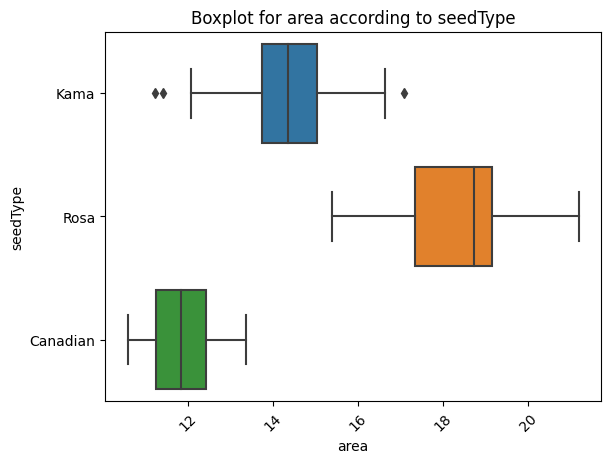

In [198]:
sns.boxplot(data=df, x="area", y="seedType")
plt.title("Boxplot for area according to seedType")
plt.xticks(rotation= 45)
plt.show()

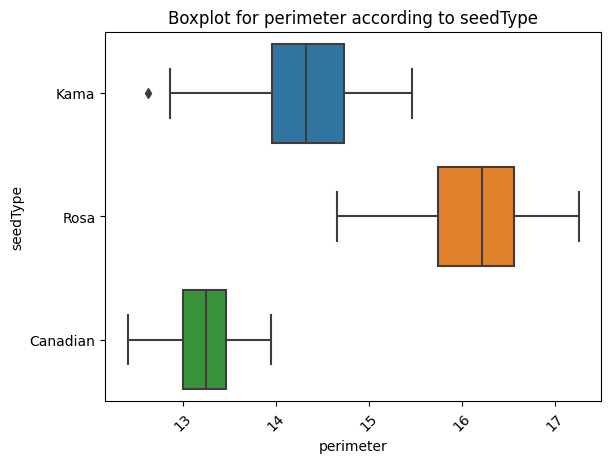

In [199]:
sns.boxplot(data=df, x="perimeter", y="seedType")
plt.title("Boxplot for perimeter according to seedType")
plt.xticks(rotation= 45)
plt.show()

As we can see, generally, the size of Canadian seed is smaller than others. In this dataset, there're some outliers in the Kama seed's distribution (smaller or bigger than usual). Can we set these values to the mean or median? Yes, however, it may incorrect if we don't really know the real "insight" of that seed's feature. The outlier Kama seed is smaller than normal.

## "compactness" analysis

In [200]:
df[df['compactness'].isna()]

,area,perimeter,compactness,lengthOfKernel,widthOfKernel,asymmetryCoefficient,lengthOfKernelGroove,seedType
19,12.720000,13.57,NaN,5.226,3.049,4.102,4.914,Kama
34,15.050000,14.68,NaN,5.712,3.328,2.129,5.360,Kama
90,20.100000,16.99,NaN,6.581,3.785,1.955,6.449,Rosa
119,20.030000,16.90,NaN,6.493,3.857,3.063,6.320,Rosa
155,11.190000,13.05,NaN,5.250,2.675,5.813,5.219,Canadian
202,10.765007,12.72,NaN,5.009,NaN,NaN,NaN,Canadian
203,12.700000,13.41,NaN,5.183,3.091,8.456,5.000,Canadian


In [201]:
df[["compactness"]].describe()

,compactness
count,203.000000
mean,0.871068
std,0.023773
min,0.808100
25%,0.856550
50%,0.873400
75%,0.888000
max,0.918300


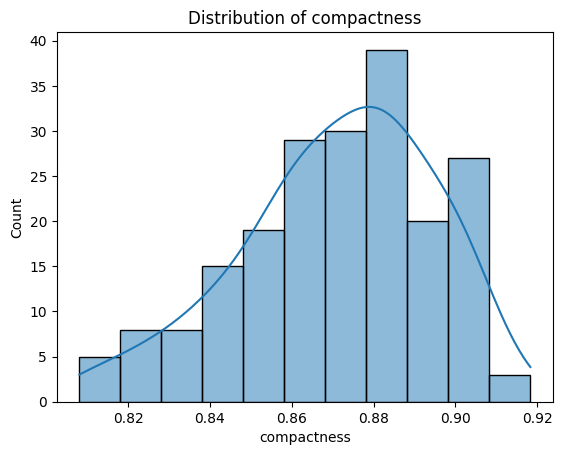

In [202]:
# plot the distribution of compactness
sns.histplot(data=df, x="compactness",  kde=True)
plt.title("Distribution of compactness")
plt.show()

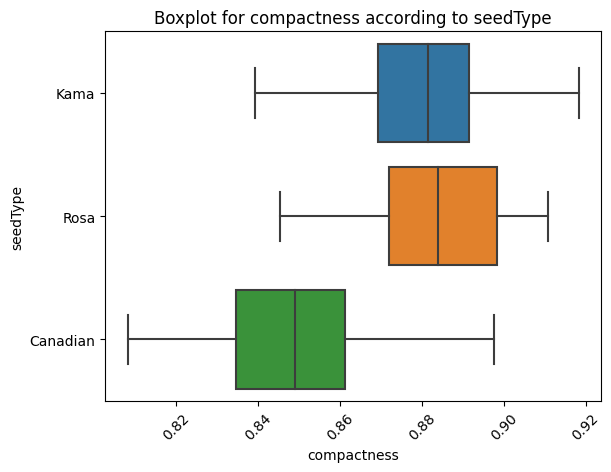

In [203]:
sns.boxplot(data=df, x="compactness", y="seedType")
plt.title("Boxplot for compactness according to seedType")
plt.xticks(rotation= 45)
plt.show()

ok, there's no outlier in each type of seed in terms of compactenss.

Text(0.5, 1.0, 'Boxplot for compactness')

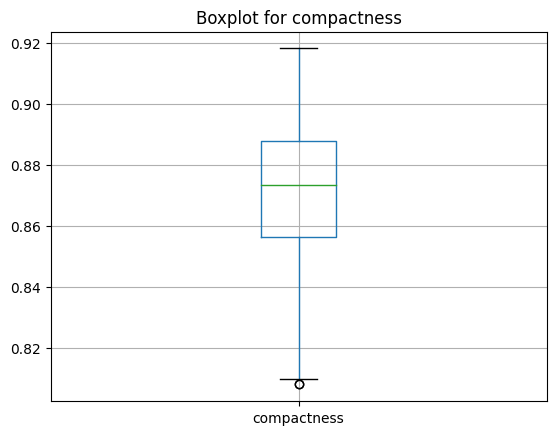

In [204]:
# boxplot for overall "compactness" distribution
df[["compactness"]].boxplot()
plt.title("Boxplot for compactness")

I'm not sure if these outliers are really outliers (in the "compactness" total distribution), but when I use the boxplot for each seedType, these values are not outliers (because seed types have different scales, for example, Canadian distribution is lower than others). Moreover, I don't have knowledge in domain (business) to determine the "right" values of compactness for each types of seed. Here, I will assume that these are actual outliers, so I gonna replace them by median.

In [205]:
# Detect outliers in compactness's distribution (whole data). 
# See "Helper functions" section for more detail.
print(df[detect_outliers_iqr(df, 'compactness')])

      area  perimeter  compactness  lengthOfKernel  widthOfKernel  \
157  12.13      13.73       0.8081           5.394          2.745   
158  11.75      13.52       0.8082           5.444          2.678   

     asymmetryCoefficient  lengthOfKernelGroove  seedType  
157                 4.825                  5.22  Canadian  
158                 4.378                  5.31  Canadian  


In [206]:
# We can compare the outlier values to top 5 smallest compactness values
df.nsmallest(5, 'compactness')

,area,perimeter,compactness,lengthOfKernel,widthOfKernel,asymmetryCoefficient,lengthOfKernelGroove,seedType
157,12.13,13.73,0.8081,5.394,2.745,4.825,5.220,Canadian
158,11.75,13.52,0.8082,5.444,2.678,4.378,5.310,Canadian
174,10.83,12.96,0.8099,5.278,2.641,5.182,5.185,Canadian
149,10.79,12.93,0.8107,5.317,2.648,5.462,5.194,Canadian
145,11.21,13.13,0.8167,5.279,2.687,6.169,5.275,Canadian


In [207]:
# Replace outliers by median according to its seedType. 
# See "Helper functions" section for more detail.
replace_outliers_with_seed_type_median(df, 'compactness')

Text(0.5, 1.0, 'Boxplot for compactness')

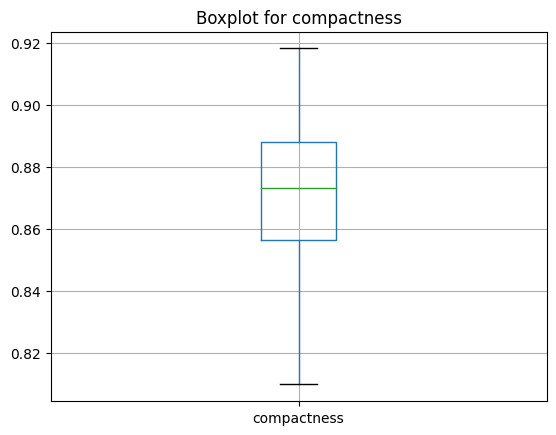

In [208]:
# boxplot for overall "compactness" distribution
df[["compactness"]].boxplot()
plt.title("Boxplot for compactness")

Cool! Now our distribution no longer has an outlier.

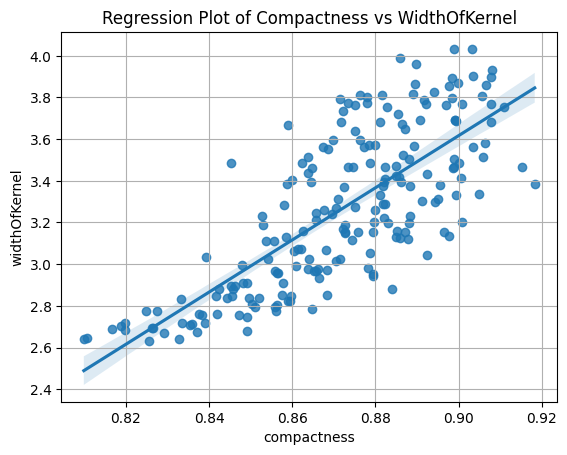

In [209]:
plt.title('Regression Plot of Compactness vs WidthOfKernel')
sns.regplot(x ='compactness', y ='widthOfKernel', data = df)
plt.xlabel('compactness')
plt.ylabel('widthOfKernel')
plt.grid(True)
plt.show()

Base on the distribution, boxplot, regression plot and correlation matrix above, I will imtpute the missing values by median value based on seedType. Because the "compactness" doesn't have very strong correlation with any other attributes (just around 0.77 with widthOfKernel), I think impute a specific value for compactness based on this attribute may not be an effective way, I think the underfitting problem will be occured when training regression models and the size of data is also limited. Moreover, the boxplot show that overall "compactness" distribution has outliers, so the mean value may be affected by these values. 

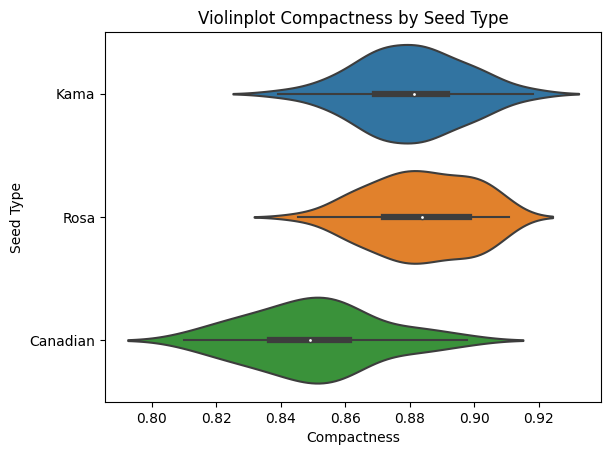

In [210]:
sns.violinplot(data=df, x="compactness", y="seedType")
plt.xlabel('Compactness')
plt.ylabel('Seed Type')
plt.title('Violinplot Compactness by Seed Type')
plt.show()

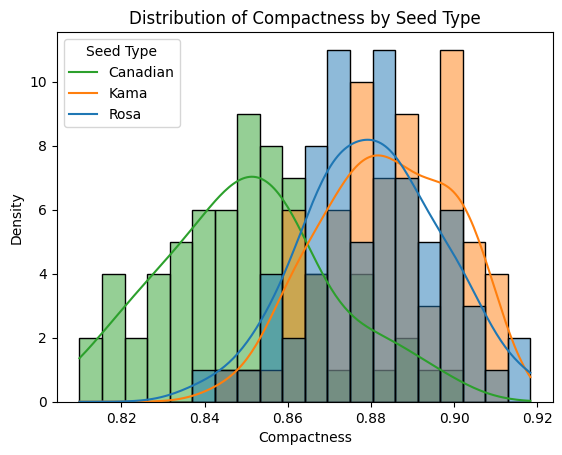

In [211]:
sns.histplot(data=df, x='compactness', hue='seedType', kde=True, bins=20)
plt.xlabel('Compactness')
plt.ylabel('Density')
plt.title('Distribution of Compactness by Seed Type')
plt.legend(title='Seed Type', labels=['Canadian', 'Kama', 'Rosa'])
plt.show()

In [212]:
#print(df[df['seedType'] == 'Kama']['compactness'].mean())
#print(df[df['seedType'] == 'Kama']['compactness'].median())

#print(df[df['seedType'] == 'Rosa']['compactness'].mean())
#print(df[df['seedType'] == 'Rosa']['compactness'].median())

#print(df[df['seedType'] == 'Canadian']['compactness'].mean())
#print(df[df['seedType'] == 'Canadian']['compactness'].median())

Filling the null values by median according seedType

In [213]:
# Calculate median compactness for each seedType
median_compactness_per_seedtype = df.groupby('seedType')['compactness'].median()

# Fill missing values based on seedType's median compactness
for seed_type, median_compactness in median_compactness_per_seedtype.items():
    df.loc[(df['seedType'] == seed_type) & (df['compactness'].isnull()), 'compactness'] = median_compactness

In [214]:
median_compactness_per_seedtype

seedType
Canadian    0.84910
Kama        0.88145
Rosa        0.88395
Name: compactness, dtype: float64

In [215]:
df['compactness'].isna().sum()

0

## "lengthOfKernel" analysis

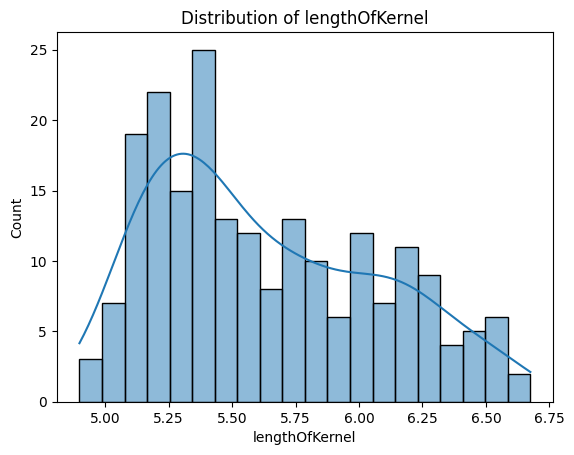

In [216]:
sns.histplot(data=df, x='lengthOfKernel', kde=True, bins=20)
plt.xlabel('lengthOfKernel')
plt.title('Distribution of lengthOfKernel')
plt.show()

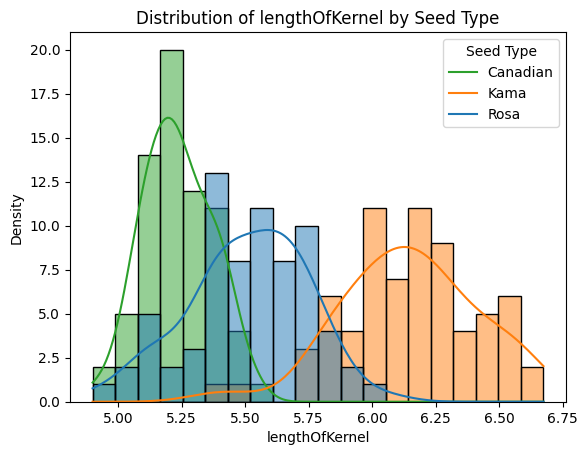

In [217]:
sns.histplot(data=df, x='lengthOfKernel', hue='seedType', kde=True, bins=20, hue_order=df['seedType'].unique())
plt.xlabel('lengthOfKernel')
plt.ylabel('Density')
plt.title('Distribution of lengthOfKernel by Seed Type')
plt.legend(title='Seed Type', labels=['Canadian', 'Kama', 'Rosa'])
plt.show()

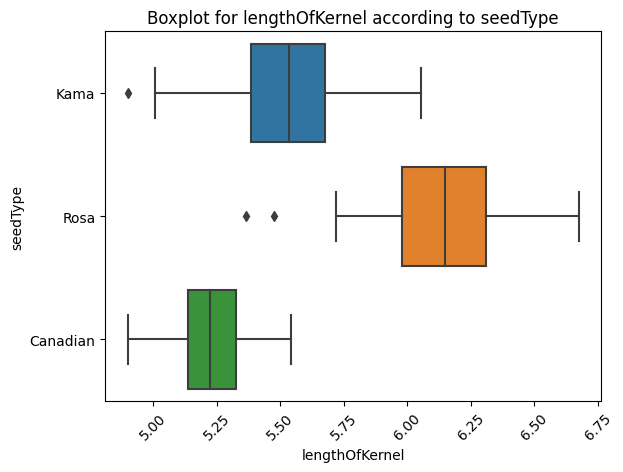

In [218]:
sns.boxplot(data=df, x="lengthOfKernel", y="seedType")
plt.title("Boxplot for lengthOfKernel according to seedType")
plt.xticks(rotation= 45)
plt.show()

There're some outliers in Rosa and Kama distributions. Like what I said before, I will not change these values because of lack of knownledge in "business" or "technical characteristic" of these seeds, I just handle the outliers in the "overall" distribution of an attribute (as compactness attribute).

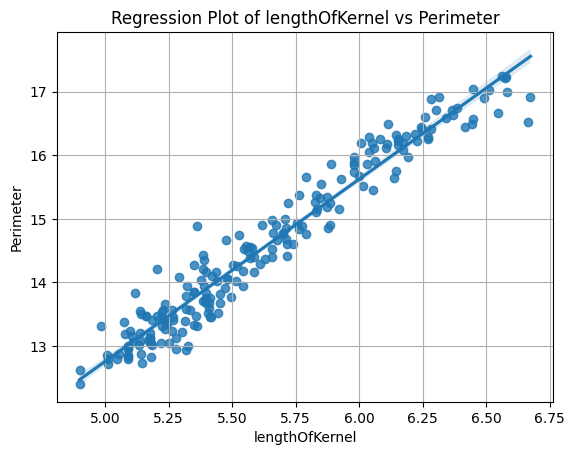

In [219]:
plt.title('Regression Plot of lengthOfKernel vs Perimeter')
sns.regplot(x ='lengthOfKernel', y ='perimeter', data = df)
plt.xlabel('lengthOfKernel')
plt.ylabel('Perimeter')
plt.grid(True)
plt.show()

Because the correlation between perimeter and lengthOfKernel is high, so I think we can use any regression model to predict null value. The linear model would be similar as above (like in area and perimeter), in this case, I just impute manually by projecting perimeter of the null-lengthOfKernel record to the regression line in the graph above to estimate the actual lengthOfKernel value.

In [220]:
# Statistical values of lengthOfKernel
df['lengthOfKernel'].describe()

count    209.000000
mean       5.631632
std        0.441841
min        4.899000
25%        5.263000
50%        5.527000
75%        5.980000
max        6.675000
Name: lengthOfKernel, dtype: float64

In [221]:
# Statistical values of lengthOfKernel when type equals Canadian
df[df['seedType'] == 'Canadian']['lengthOfKernel'].describe()

count    69.000000
mean      5.233116
std       0.135672
min       4.899000
25%       5.137000
50%       5.224000
75%       5.325000
max       5.541000
Name: lengthOfKernel, dtype: float64

In [222]:
df[df['seedType'] == 'Canadian']['perimeter'].describe()

count    70.000000
mean     13.250516
std       0.335516
min      12.410000
25%      13.002500
50%      13.250000
75%      13.470000
max      13.950000
Name: perimeter, dtype: float64

In [223]:
# Top 10 records with the least values in the 'perimeter' column
df.nsmallest(10, 'perimeter')

,area,perimeter,compactness,lengthOfKernel,widthOfKernel,asymmetryCoefficient,lengthOfKernelGroove,seedType
189,10.590000,12.410000,0.8648,4.899,2.787,4.975,4.794,Canadian
61,11.230000,12.630000,0.8840,4.902,2.879,2.269,4.703,Kama
202,10.765007,12.720000,0.8491,5.009,NaN,NaN,NaN,Canadian
177,10.740000,12.730000,0.8329,5.145,2.642,4.702,4.963,Canadian
175,10.800000,12.756102,0.8590,NaN,2.821,NaN,NaN,Canadian
164,11.140000,12.790000,0.8558,5.011,2.794,6.388,5.049,Canadian
187,10.910000,12.800000,0.8372,5.088,2.675,4.179,4.956,Canadian
190,10.930000,12.800000,0.8390,5.046,2.717,5.398,5.045,Canadian
188,11.230000,12.820000,0.8594,5.089,2.821,7.524,4.957,Canadian
193,10.820000,12.830000,0.8256,5.180,2.630,4.853,5.089,Canadian


In [224]:
df[df['lengthOfKernel'].isna()]

,area,perimeter,compactness,lengthOfKernel,widthOfKernel,asymmetryCoefficient,lengthOfKernelGroove,seedType
175,10.8,12.756102,0.859,NaN,2.821,NaN,NaN,Canadian


We can see that the perimeter value is 12.756 and the type is Canadian, so the lengthOfKernel will be around 5.0 to 5.145.
I think that the lengthOfKernel value 5.145 in the record 177 is high a little bit (because the its perimeter is just 12.73), I gonna choose randomly number 5 to replace the null value.

In [225]:
# replace null value by number 5
df['lengthOfKernel'].fillna(5, inplace=True)

In [226]:
# Cool, there's no null value in this attribute
df['lengthOfKernel'].isna().sum()

0

In [227]:
# Okay, this is one of the alternative way to handle missing value by median.
# Please uncomment if you wanna use this method.
# There's only 1 null value of this feature.
# Calculate median lengthOfKernel for each seedType

#median_lengthOfKernel_per_seedtype = df.groupby('seedType')['lengthOfKernel'].median()

# Fill missing values based on seedType's median lengthOfKernel
#for seed_type, median_lengthOfKernel in median_lengthOfKernel_per_seedtype.items():
#    df.loc[(df['seedType'] == seed_type) & (df['lengthOfKernel'].isnull()), 'lengthOfKernel'] = median_lengthOfKernel

#print(median_lengthOfKernel_per_seedtype)

## "widthOfKernel" analysis

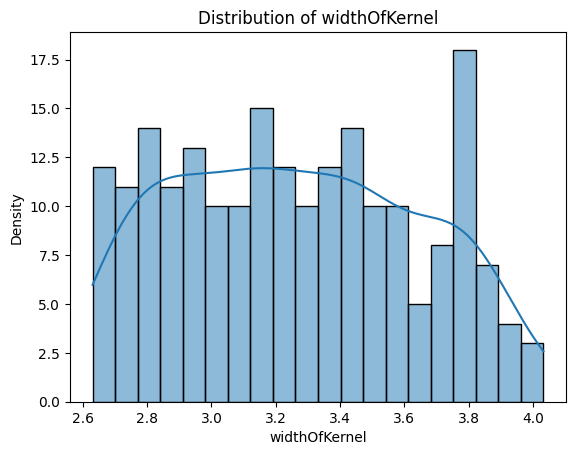

In [228]:
sns.histplot(data=df, x='widthOfKernel', kde=True, bins=20)
plt.xlabel('widthOfKernel')
plt.ylabel('Density')
plt.title('Distribution of widthOfKernel')
plt.show()

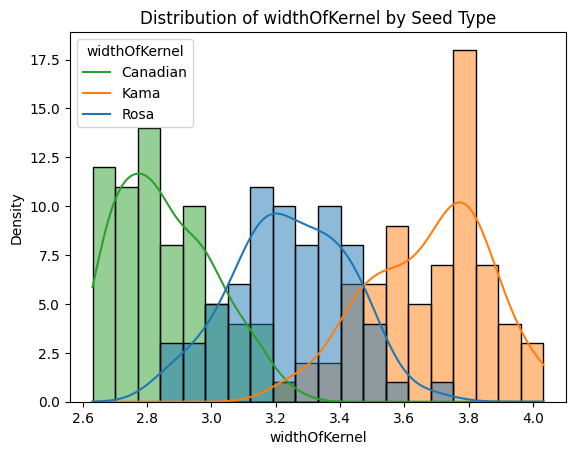

In [229]:
sns.histplot(data=df, x='widthOfKernel', hue='seedType', kde=True, bins=20)
plt.xlabel('widthOfKernel')
plt.ylabel('Density')
plt.title('Distribution of widthOfKernel by Seed Type')
plt.legend(title='widthOfKernel', labels=['Canadian', 'Kama', 'Rosa'])
plt.show()

We can apparently see that 3 types of seed have different width of kernel. About 3.8 is the common kernel width of Kama seeds

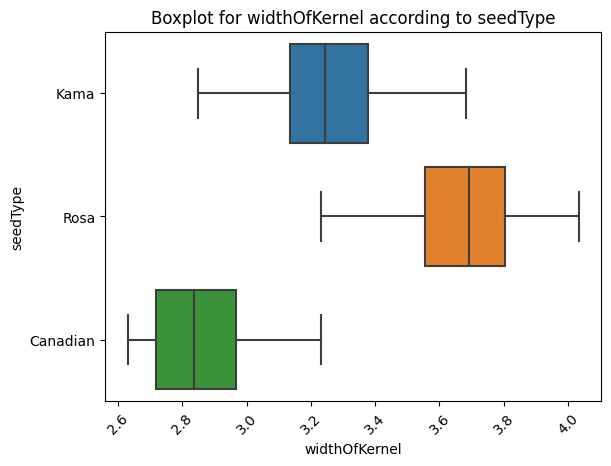

In [230]:
sns.boxplot(data=df, x="widthOfKernel", y="seedType")
plt.title("Boxplot for widthOfKernel according to seedType")
plt.xticks(rotation= 45)
plt.show()

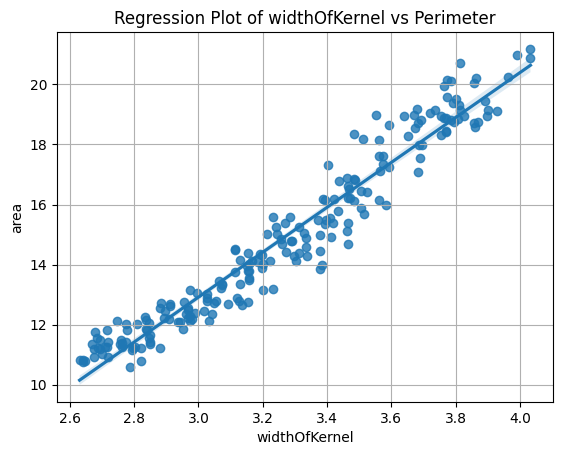

In [231]:
plt.title('Regression Plot of widthOfKernel vs Perimeter')
sns.regplot(x ='widthOfKernel', y ='area', data = df)
plt.xlabel('widthOfKernel')
plt.ylabel('area')
plt.grid(True)
plt.show()

Here, I do the same thing as lenghtOfKernel, however, widthOfKernel has strong correlation with area instead of perimeter.

In [232]:
df[df['widthOfKernel'].isna()]

,area,perimeter,compactness,lengthOfKernel,widthOfKernel,asymmetryCoefficient,lengthOfKernelGroove,seedType
202,10.765007,12.72,0.8491,5.009,NaN,NaN,NaN,Canadian


In [233]:
df['widthOfKernel'].describe()

count    209.000000
mean       3.260751
std        0.377335
min        2.630000
25%        2.953000
50%        3.242000
75%        3.562000
max        4.033000
Name: widthOfKernel, dtype: float64

In [234]:
df[df['seedType'] == 'Canadian']['widthOfKernel'].describe()

count    69.000000
mean      2.854406
std       0.148501
min       2.630000
25%       2.719000
50%       2.836000
75%       2.967000
max       3.232000
Name: widthOfKernel, dtype: float64

In [235]:
# Top 10 records with the least values in the 'area' column
df.nsmallest(10, 'area')

,area,perimeter,compactness,lengthOfKernel,widthOfKernel,asymmetryCoefficient,lengthOfKernelGroove,seedType
189,10.590000,12.410000,0.8648,4.899,2.787,4.975,4.794,Canadian
177,10.740000,12.730000,0.8329,5.145,2.642,4.702,4.963,Canadian
202,10.765007,12.720000,0.8491,5.009,NaN,NaN,NaN,Canadian
149,10.790000,12.930000,0.8107,5.317,2.648,5.462,5.194,Canadian
175,10.800000,12.756102,0.8590,5.000,2.821,NaN,NaN,Canadian
193,10.820000,12.830000,0.8256,5.180,2.630,4.853,5.089,Canadian
174,10.830000,12.960000,0.8099,5.278,2.641,5.182,5.185,Canadian
187,10.910000,12.800000,0.8372,5.088,2.675,4.179,4.956,Canadian
190,10.930000,12.800000,0.8390,5.046,2.717,5.398,5.045,Canadian
170,11.020000,13.000000,0.8189,5.325,2.701,6.735,5.163,Canadian


In [236]:
# replace null value by number 2.640
df['widthOfKernel'].fillna(2.640, inplace=True)
print(df['widthOfKernel'].isna().sum())

0


## "asymmetryCoefficient" analysis

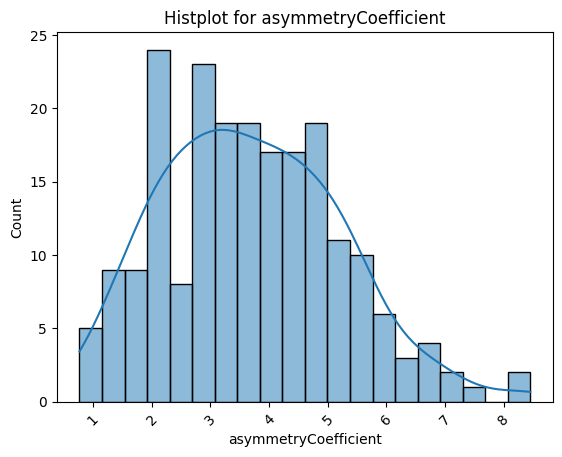

In [237]:
sns.histplot(data=df, x="asymmetryCoefficient", kde=True, bins=20)
plt.title("Histplot for asymmetryCoefficient")
plt.xticks(rotation= 45)
plt.show()

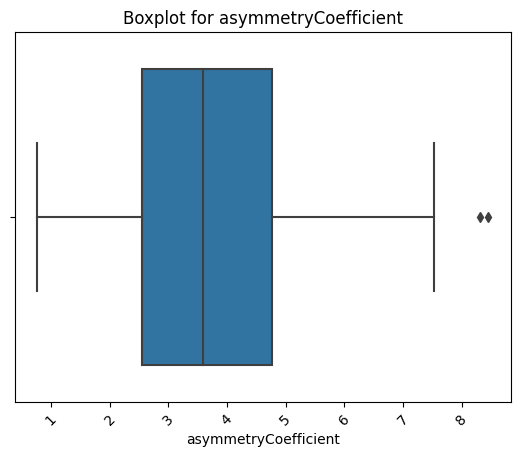

In [238]:
sns.boxplot(data=df, x="asymmetryCoefficient")
plt.title("Boxplot for asymmetryCoefficient")
plt.xticks(rotation= 45)
plt.show()

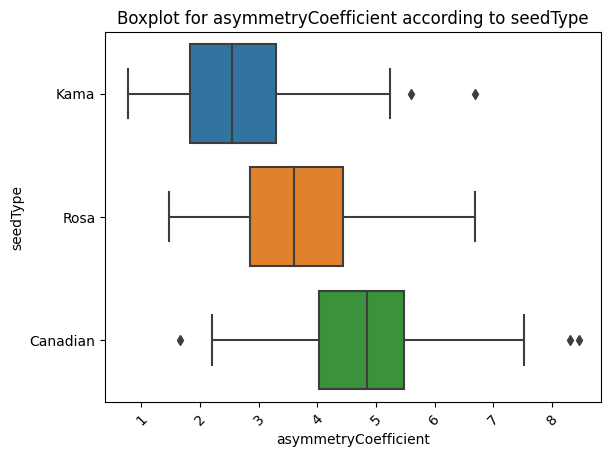

In [239]:
sns.boxplot(data=df, x="asymmetryCoefficient", y="seedType")
plt.title("Boxplot for asymmetryCoefficient according to seedType")
plt.xticks(rotation= 45)
plt.show()

I gonna handle the outliers first before handling null values.

In [240]:
print(df[detect_outliers_iqr(df, 'asymmetryCoefficient')])

     area  perimeter  compactness  lengthOfKernel  widthOfKernel  \
203  12.7      13.41       0.8491           5.183          3.091   
207  13.2      13.66       0.8883           5.236          3.232   

     asymmetryCoefficient  lengthOfKernelGroove  seedType  
203                 8.456                 5.000  Canadian  
207                 8.315                 5.056  Canadian  


In [241]:
# Look the "Helper functions" section for more detail
replace_outliers_with_seed_type_median(df, 'asymmetryCoefficient')

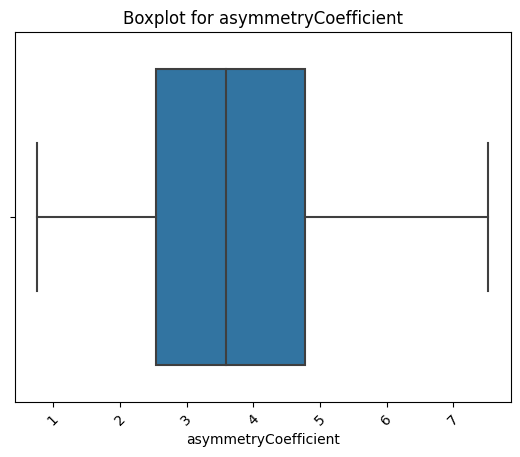

In [242]:
# Ok, outliers have been replaced.
sns.boxplot(data=df, x="asymmetryCoefficient")
plt.title("Boxplot for asymmetryCoefficient")
plt.xticks(rotation= 45)
plt.show()

Look at the correlation matrix above, we can see that this attribute doesn't have strong correlation with any other attribute, so I think a possible solution to handle null values is... replacing by median again :D Of course, I gonna rely on those seedTypes.  

In [243]:
df[df['asymmetryCoefficient'].isna()]

,area,perimeter,compactness,lengthOfKernel,widthOfKernel,asymmetryCoefficient,lengthOfKernelGroove,seedType
175,10.800000,12.756102,0.8590,5.000,2.821,NaN,NaN,Canadian
202,10.765007,12.720000,0.8491,5.009,2.640,NaN,NaN,Canadian


In [244]:
# See "Helper functions".
replace_null_with_seed_type_median(df, 'asymmetryCoefficient')

In [245]:
df['asymmetryCoefficient'].isna().sum()

0

In [246]:
df['asymmetryCoefficient'].describe()

count    210.000000
mean       3.670787
std        1.438438
min        0.765100
25%        2.561500
50%        3.599000
75%        4.846000
max        7.524000
Name: asymmetryCoefficient, dtype: float64

## "lengthOfKernelGroove" analysis

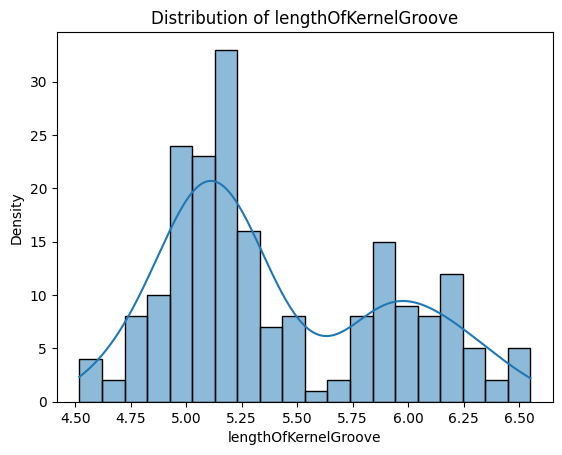

In [247]:
sns.histplot(data=df, x='lengthOfKernelGroove', kde=True, bins=20)
plt.xlabel('lengthOfKernelGroove')
plt.ylabel('Density')
plt.title('Distribution of lengthOfKernelGroove')
plt.show()

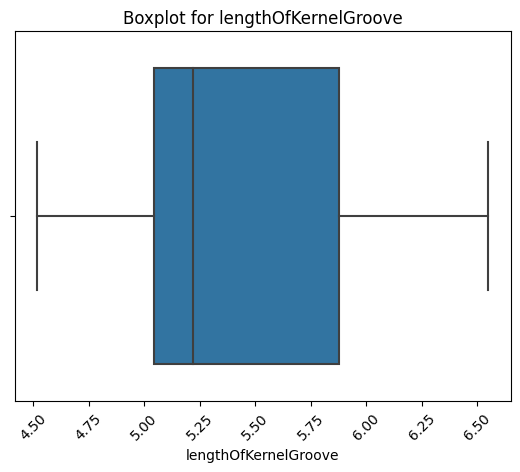

In [248]:
sns.boxplot(data=df, x="lengthOfKernelGroove")
plt.title("Boxplot for lengthOfKernelGroove")
plt.xticks(rotation= 45)
plt.show()

There's no outlier.

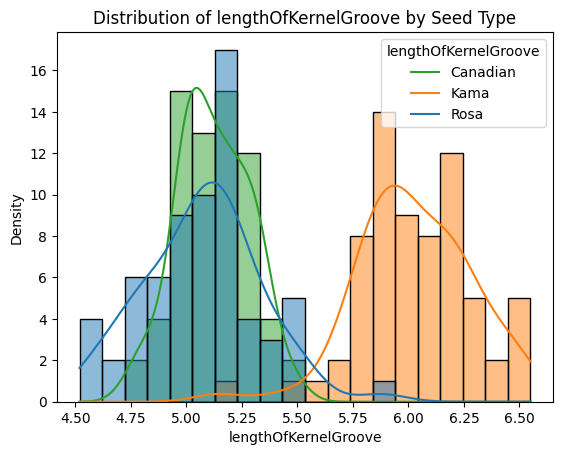

In [249]:
sns.histplot(data=df, x='lengthOfKernelGroove', hue='seedType', kde=True, bins=20)
plt.xlabel('lengthOfKernelGroove')
plt.ylabel('Density')
plt.title('Distribution of lengthOfKernelGroove by Seed Type')
plt.legend(title='lengthOfKernelGroove', labels=['Canadian', 'Kama', 'Rosa'])
plt.show()

It seems like the Kama lengthOfKernelGroove values are much higher than others and it has an outlier (around 5.20). Rosa also has an outlier.

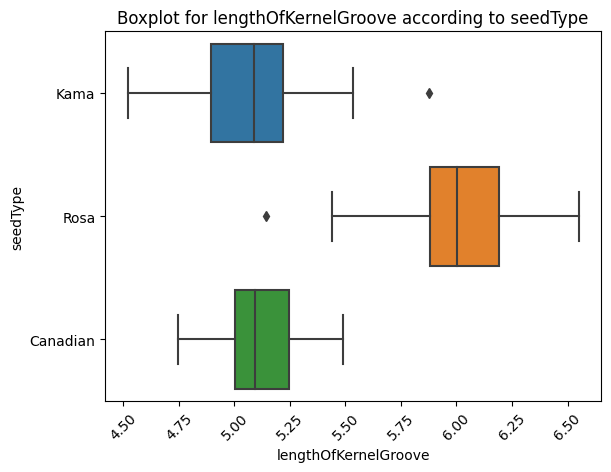

In [250]:
sns.boxplot(data=df, x="lengthOfKernelGroove", y="seedType")
plt.title("Boxplot for lengthOfKernelGroove according to seedType")
plt.xticks(rotation= 45)
plt.show()

Not unexpected :V The mean values of Kama and Canadian look similar, but they have different variances (Kama is larger). Cool! Let's check those values.

In [251]:
print("Kama mean:", df[df['seedType'] == 'Kama']['lengthOfKernelGroove'].mean())
print("Canadian mean:", df[df['seedType'] == 'Canadian']['lengthOfKernelGroove'].mean())

print("Kama median:", df[df['seedType'] == 'Kama']['lengthOfKernelGroove'].median())
print("Canadian median:", df[df['seedType'] == 'Canadian']['lengthOfKernelGroove'].median())

print("Kama std:", df[df['seedType'] == 'Kama']['lengthOfKernelGroove'].std())
print("Canadian std:", df[df['seedType'] == 'Canadian']['lengthOfKernelGroove'].std())

Kama mean: 5.0721791044776126
Canadian mean: 5.121268656716416
Kama median: 5.088
Canadian median: 5.092
Kama std: 0.2587282372855403
Canadian std: 0.16164425793676007


In [252]:
df[df['lengthOfKernelGroove'].isna()]

,area,perimeter,compactness,lengthOfKernel,widthOfKernel,asymmetryCoefficient,lengthOfKernelGroove,seedType
32,14.090000,14.410000,0.8529,5.717,3.186,3.920,NaN,Kama
35,16.120000,15.000000,0.9000,5.709,3.485,2.270,NaN,Kama
36,16.200000,15.270000,0.8734,5.826,3.464,2.823,NaN,Kama
101,17.990000,15.860000,0.8992,5.890,3.694,2.068,NaN,Rosa
123,18.430000,15.970000,0.9077,5.980,3.771,2.984,NaN,Rosa
168,11.350000,13.120000,0.8291,5.176,2.668,4.337,NaN,Canadian
175,10.800000,12.756102,0.8590,5.000,2.821,4.854,NaN,Canadian
202,10.765007,12.720000,0.8491,5.009,2.640,4.854,NaN,Canadian


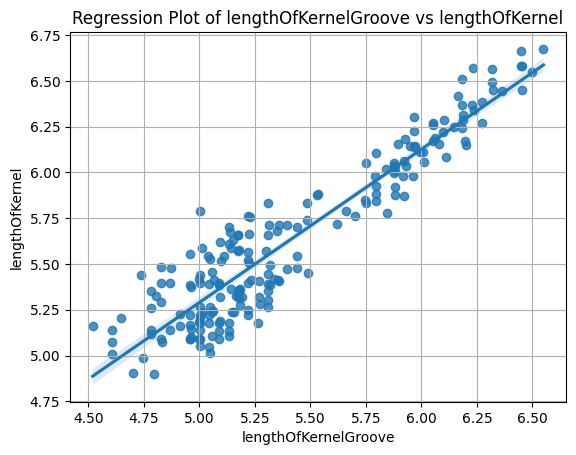

In [253]:
plt.title('Regression Plot of lengthOfKernelGroove vs lengthOfKernel')
sns.regplot(x ='lengthOfKernelGroove', y ='lengthOfKernel', data = df)
plt.xlabel('lengthOfKernelGroove')
plt.ylabel('lengthOfKernel')
plt.grid(True)
plt.show()

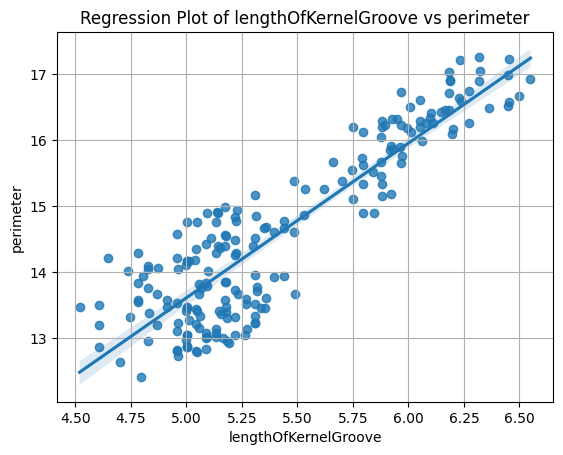

In [254]:
plt.title('Regression Plot of lengthOfKernelGroove vs perimeter')
sns.regplot(x ='lengthOfKernelGroove', y ='perimeter', data = df)
plt.xlabel('lengthOfKernelGroove')
plt.ylabel('perimeter')
plt.grid(True)
plt.show()

In [255]:
# Split the DataFrame into non-null 'lengthOfKernel' and null 'lengthOfKernelGroove' parts
non_null_data = df.dropna(subset=['perimeter', 'lengthOfKernel', 'lengthOfKernelGroove'])
null_data = df[df[['perimeter', 'lengthOfKernelGroove']].isnull().any(axis=1)]

# Create a linear regression model
lengthOfKernelGroove_model = LinearRegression()
lengthOfKernelGroove_model.fit(non_null_data[['perimeter', 'lengthOfKernel']], non_null_data['lengthOfKernelGroove'])


LinearRegression()

In [256]:
null_data

,area,perimeter,compactness,lengthOfKernel,widthOfKernel,asymmetryCoefficient,lengthOfKernelGroove,seedType
32,14.090000,14.410000,0.8529,5.717,3.186,3.920,NaN,Kama
35,16.120000,15.000000,0.9000,5.709,3.485,2.270,NaN,Kama
36,16.200000,15.270000,0.8734,5.826,3.464,2.823,NaN,Kama
101,17.990000,15.860000,0.8992,5.890,3.694,2.068,NaN,Rosa
123,18.430000,15.970000,0.9077,5.980,3.771,2.984,NaN,Rosa
168,11.350000,13.120000,0.8291,5.176,2.668,4.337,NaN,Canadian
175,10.800000,12.756102,0.8590,5.000,2.821,4.854,NaN,Canadian
202,10.765007,12.720000,0.8491,5.009,2.640,4.854,NaN,Canadian


In [257]:
# Predict null lengthOfKernelGroove values
predicted_groove_lengths = lengthOfKernelGroove_model.predict(null_data[['perimeter', 'lengthOfKernel']])
print("Predicted values:", predicted_groove_lengths)

Predicted values: [5.54698825 5.46275854 5.59258608 5.60882693 5.7207926  4.95181876
 4.75128963 4.76831935]


In [258]:
# Evaluate the model
true_values = non_null_data['lengthOfKernelGroove']
predicted_values = lengthOfKernelGroove_model.predict(non_null_data[['perimeter', 'lengthOfKernel']])
mae = mean_absolute_error(true_values, predicted_values)
mse = mean_squared_error(true_values, predicted_values)
r2 = r2_score(true_values, predicted_values)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Absolute Error: 0.1390493261609236
Mean Squared Error: 0.029842324809660776
R-squared: 0.8782053713928181


In [259]:
# Replace null values with predicted values
df.loc[df['lengthOfKernelGroove'].isnull(), 'lengthOfKernelGroove'] = predicted_groove_lengths

In [260]:
df['lengthOfKernelGroove'].isnull().sum()

0

In [261]:
df['lengthOfKernelGroove'].describe()

count    210.000000
mean       5.405068
std        0.492703
min        4.519000
25%        5.044000
50%        5.223000
75%        5.877000
max        6.550000
Name: lengthOfKernelGroove, dtype: float64

# Part 2: K-means clustering

Because the data contains categorical data (seedType), I have to change the type to integer using One-hot Encoder which creates binary columns for each category in our categorical variable. Each row will have a 1 in the column corresponding to its category and 0s in the others. Because the order of values is not matter, so we should not use Label Encoder for this.

In [262]:
df_encoded = pd.get_dummies(df, columns=['seedType'], prefix=['seedType'])

In [263]:
df_encoded

,area,perimeter,compactness,lengthOfKernel,widthOfKernel,asymmetryCoefficient,lengthOfKernelGroove,seedType_Canadian,seedType_Kama,seedType_Rosa
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,False,True,False
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,False,True,False
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,False,True,False
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,False,True,False
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,False,True,False
...,...,...,...,...,...,...,...,...,...,...
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,True,False,False
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,True,False,False
207,13.20,13.66,0.8883,5.236,3.232,4.855,5.056,True,False,False
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,True,False,False


Hmmmmmmmmmm, I decided to eliminate the column "seedType" because I consider it as a real-label column, I gonna check the output of clustering labels with them later.

In [264]:
df2 = df.loc[:, df.columns != 'seedType'] # without categorical column

I gonna use StandardScaler to scale my data, because the measures of each attribute are different. The values will be in the range [-1 , 1]

In [265]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df2)

In [266]:
scaled_data

array([[ 0.14264901,  0.21499524, -0.01603883, ...,  0.14341485,
        -1.01029764, -0.3765165 ],
       [ 0.01185804,  0.00755104,  0.42690845, ...,  0.19897661,
        -1.84861965, -0.91361693],
       [-0.19121214, -0.36123865,  1.4750708 , ...,  0.2095598 ,
        -0.67719879, -1.18013267],
       ...,
       [-0.56637569, -0.69161275,  0.74267284, ..., -0.06824899,
         0.82523034, -0.7101698 ],
       [-1.03446967, -1.03735309, -0.84492036, ..., -1.11598498,
        -0.05072208, -0.73458345],
       [-0.87614376, -0.93747254, -0.13006486, ..., -0.75086486,
         1.37017448, -0.6959285 ]])

Here, to decide the number of K, I use Elbow method to determine it. We can see that, the K = 3 is an "optimal" K we have, this number is same as what we have when doing EDA (we have 3 main types of seeds based on seedType column)

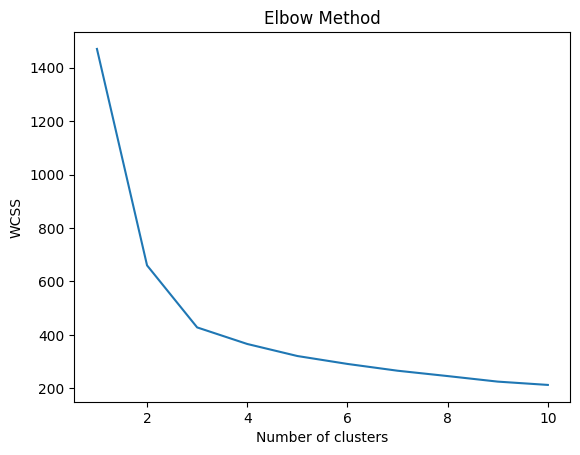

In [267]:
wcss = []  # Within-cluster sum of squares

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(scaled_data) 
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [268]:
# Choose the optimal number of clusters based on the elbow method (K = 3)
optimal_num_clusters = 3 

kmeans = KMeans(n_clusters=optimal_num_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
cluster_labels = kmeans.fit_predict(scaled_data) 

df['cluster'] = cluster_labels


In [269]:
df

,area,perimeter,compactness,lengthOfKernel,widthOfKernel,asymmetryCoefficient,lengthOfKernelGroove,seedType,cluster
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,Kama,2
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,Kama,2
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,Kama,2
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,Kama,2
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,Kama,2
...,...,...,...,...,...,...,...,...,...
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,Canadian,2
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,Canadian,1
207,13.20,13.66,0.8883,5.236,3.232,4.855,5.056,Canadian,2
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,Canadian,1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


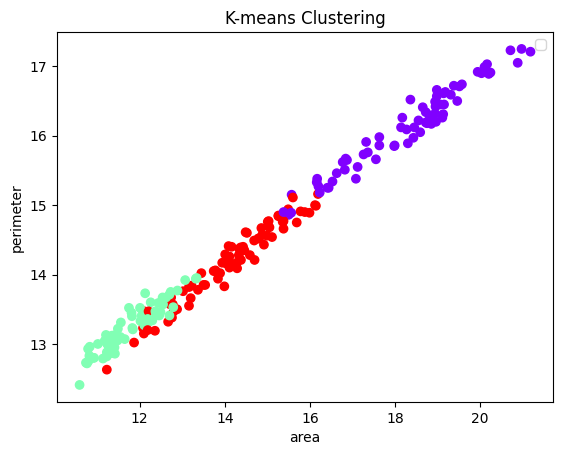

In [270]:
plt.scatter(df['area'], df['perimeter'], c=df['cluster'], cmap='rainbow')
plt.xlabel('area')
plt.ylabel('perimeter')
plt.title('K-means Clustering')
plt.legend()
plt.show()


It's obviously that 3 clusters have different sizes (like 3 types of seed)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


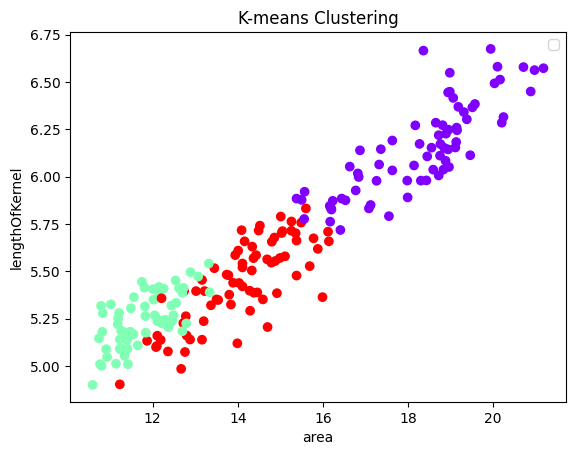

In [271]:
plt.scatter(df['area'], df['lengthOfKernel'], c=df['cluster'], cmap='rainbow')
plt.xlabel('area')
plt.ylabel('lengthOfKernel')
plt.title('K-means Clustering')
plt.legend()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


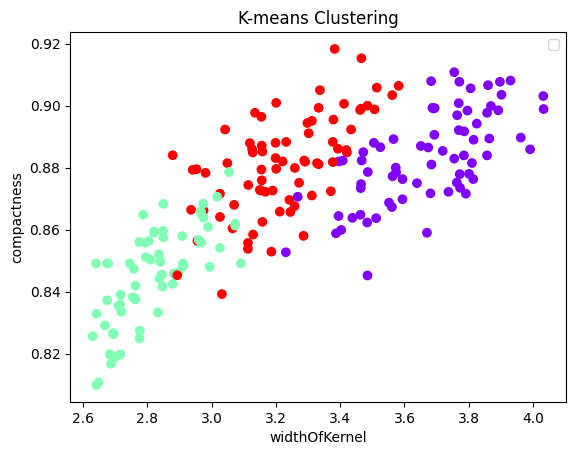

In [272]:
plt.scatter(df['widthOfKernel'], df['compactness'], c=df['cluster'], cmap='rainbow')
plt.xlabel('widthOfKernel')
plt.ylabel('compactness')
plt.title('K-means Clustering')
plt.legend()
plt.show()


It can be seen that there is overlap between cluster regions, the reason is that the input values are all attributes in the dataset but we can show only maximum 3 dimensions in a graph for visualisation, the other dimensions are not showed. Here, I just show some high-correlation pairs of attributes. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


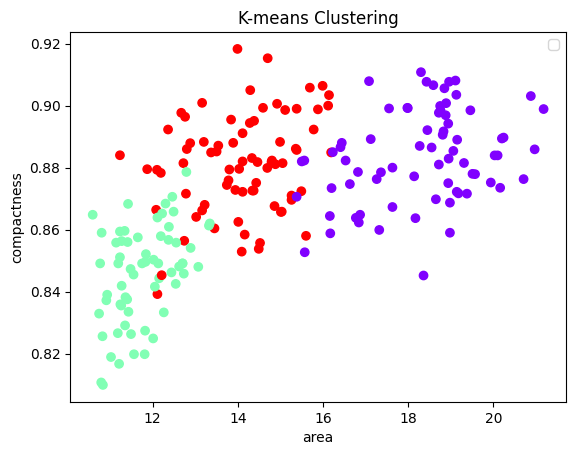

In [273]:
plt.scatter(df['area'], df['compactness'], c=df['cluster'], cmap='rainbow')
plt.xlabel('area')
plt.ylabel('compactness')
plt.title('K-means Clustering')
plt.legend()
plt.show()


okay, I gonna check the true label df['seedType'] with our clustering label df['cluster'] are same or not.

In [274]:
# Extract cluster and seedType labels
cluster_labels = df['cluster']
seedType_labels = df['seedType']

# Calculate Adjusted Rand Index (ARI)
ari = adjusted_rand_score(seedType_labels, cluster_labels)

# Calculate Normalized Mutual Information (NMI)
nmi = normalized_mutual_info_score(seedType_labels, cluster_labels)

print("Adjusted Rand Index (ARI):", ari)
print("Normalized Mutual Information (NMI):", nmi)

Adjusted Rand Index (ARI): 0.7488545901803169
Normalized Mutual Information (NMI): 0.7115474265018028


For more detail of ARI and NMI, read here: https://stats.stackexchange.com/questions/260487/adjusted-rand-index-vs-adjusted-mutual-information

Cool! The result is quite good, although there're some mis-labels, I think this because of the outliers.

In [275]:
df

,area,perimeter,compactness,lengthOfKernel,widthOfKernel,asymmetryCoefficient,lengthOfKernelGroove,seedType,cluster
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,Kama,2
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,Kama,2
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,Kama,2
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,Kama,2
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,Kama,2
...,...,...,...,...,...,...,...,...,...
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,Canadian,2
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,Canadian,1
207,13.20,13.66,0.8883,5.236,3.232,4.855,5.056,Canadian,2
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,Canadian,1


Limitation: Well, the K-means using Euclidean distance is not effective in high-dimensional data, in this dataset, we only have 7 features (and 1 column seedType considered as label column). In the high-dimensional data, the distance between points are becoming sparse because of the curve of dimensionality, so we are not sure when one point to another is really "close" based on the Euclidean distance, the clustering label would be wrong. The k-means algorithm is also affected by the density of the data.

# Part 3: PCA

In [276]:
pca = PCA()
pca.fit(scaled_data)

PCA()

In [277]:
# Determine the optimal number of components using the explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()
print(explained_variance)
print(cumulative_variance)


[7.21106278e-01 1.75744448e-01 8.96152729e-02 9.44105295e-03
 3.03724004e-03 9.11722698e-04 1.43984709e-04]
[0.72110628 0.89685073 0.986466   0.99590705 0.99894429 0.99985602
 1.        ]


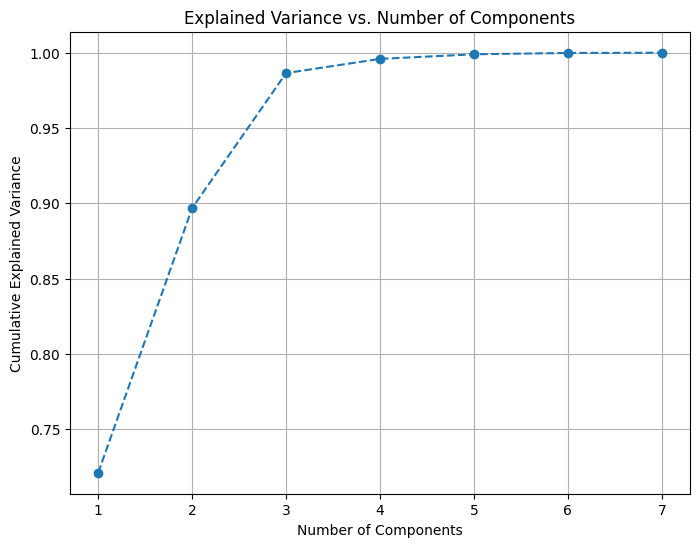

In [278]:
# Plot the explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()


In [279]:
print(cumulative_variance)

[0.72110628 0.89685073 0.986466   0.99590705 0.99894429 0.99985602
 1.        ]


Explained variance is a statistical measure of how much variation in a dataset can be attributed to each of the principal components (eigenvectors) generated by the principal component analysis (PCA) method. The cumulative explained variance shows the accumulation of variance for each principal component number. The individual explained variance describes the variance of each principal component. Here, with 1 component we can represent around 72.11% variance of the original dataset, with 2 components is 89.68%, and 3 components is around 98.64%, etc.

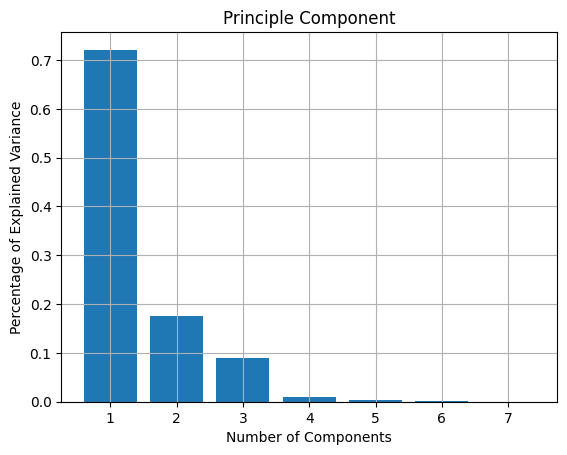

In [280]:
plt.bar(range(1, len(explained_variance) + 1), explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Percentage of Explained Variance')
plt.title('Principle Component')
plt.grid(True)
plt.show()

We can see almost of variation is along the first component, and we can "explain" the dataset with just 3 components (less than 7 original attributes) with acceptable loss.

In [281]:
# Based on the plot above, I choose 3 components
# You can change to any number (less than 7).
n_components = 3

# Apply PCA with the selected number of components
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(scaled_data)

# Create a new dataframe with 3 components
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i}' for i in range(1, n_components + 1)])


In [282]:
print("PCA Results:")
print(pca_df)

PCA Results:
          PC1       PC2       PC3
0    0.319143  0.794624 -0.649995
1    0.011471  1.959074 -0.691583
2   -0.434521  1.920723  0.965941
3   -0.571399  1.951536  0.515933
4    1.128066  2.112438  0.057401
..        ...       ...       ...
205 -1.984199  0.850025  0.535628
206 -2.739427 -0.250684 -0.054827
207 -1.124020  0.308634  1.386306
208 -2.349117  0.075444 -0.389687
209 -1.964369 -0.596834  1.053802

[210 rows x 3 columns]


In [283]:
pca_result

array([[ 3.19142959e-01,  7.94624222e-01, -6.49995360e-01],
       [ 1.14710017e-02,  1.95907372e+00, -6.91582515e-01],
       [-4.34520584e-01,  1.92072289e+00,  9.65941008e-01],
       [-5.71398974e-01,  1.95153632e+00,  5.15933300e-01],
       [ 1.12806631e+00,  2.11243846e+00,  5.74008975e-02],
       [-3.17956318e-01,  1.65277512e+00,  4.55573247e-01],
       [-1.42256959e-01,  4.17498334e-01,  3.15671956e-01],
       [-4.10148222e-01,  1.39866033e+00,  4.16473038e-01],
       [ 1.76790055e+00,  3.24721730e-01, -1.00095259e+00],
       [ 1.45232035e+00,  1.03436056e+00, -3.96119171e-01],
       [ 5.91583888e-02, -4.78004860e-01,  3.41658942e-01],
       [-5.60433855e-01,  1.58818488e+00, -4.33751525e-01],
       [-9.21585148e-01,  8.47686113e-01,  9.86307972e-01],
       [-9.09850642e-01,  8.63459596e-01,  1.44480081e-01],
       [-1.00307416e+00,  9.54947066e-01,  3.11526374e-03],
       [-5.00255163e-01,  1.03035622e+00,  1.48794927e+00],
       [-7.60671513e-01,  1.09552392e+00

In [284]:
pca.components_

array([[ 0.44360578,  0.44087036,  0.28275931,  0.42281889,  0.43213831,
        -0.11924299,  0.38620744],
       [-0.02909498, -0.08512987,  0.52235551, -0.20602249,  0.1126011 ,
        -0.72311337, -0.37554478],
       [ 0.02692647, -0.05799975,  0.631204  , -0.2173713 ,  0.21662547,
         0.67337023, -0.22335658]])

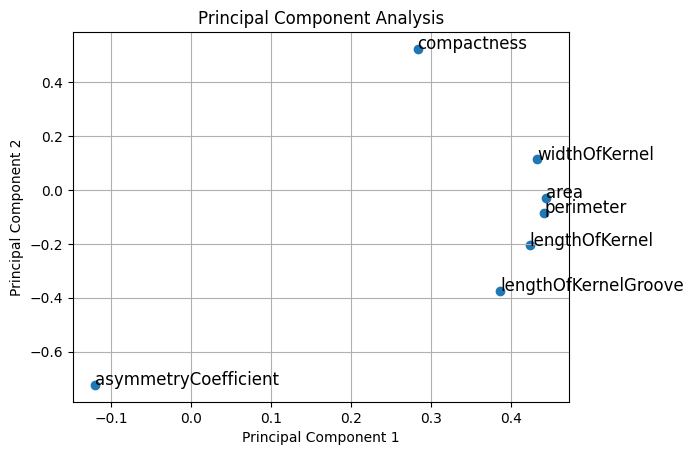

In [285]:
components = pca.components_
# Visualize the components
plt.scatter(components[0], components[1], marker='o')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Principal Component Analysis')
plt.grid(True)

# Add labels for original features
for i, feature in enumerate(df2.columns):
    plt.annotate(feature, (components[0][i], components[1][i]), fontsize=12)

plt.show()

we can see on the right-hand side, these attributes are clustered, suggesting that they are correlated with each other. The separation of two clusters along x-axis suggests that asymmetryCoefficient are very different from the other attributes. We can explain the graphs below similarly.

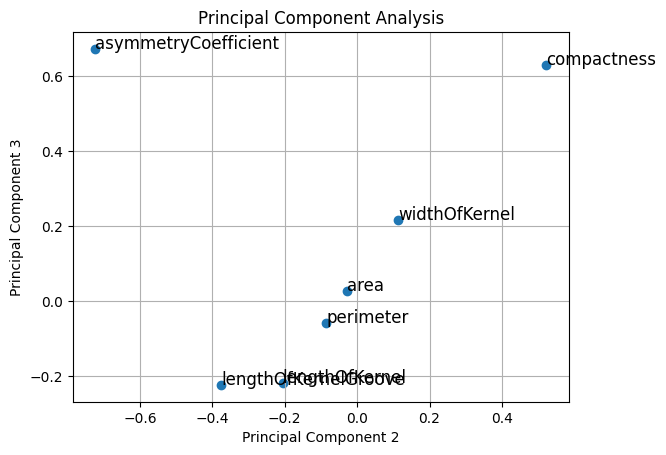

In [286]:
# Visualize the components
plt.scatter(components[1], components[2], marker='o')
plt.xlabel('Principal Component 2')
plt.ylabel('Principal Component 3')
plt.title('Principal Component Analysis')
plt.grid(True)

# Add labels for original features
for i, feature in enumerate(df2.columns):
    plt.annotate(feature, (components[1][i], components[2][i]), fontsize=12)

plt.show()

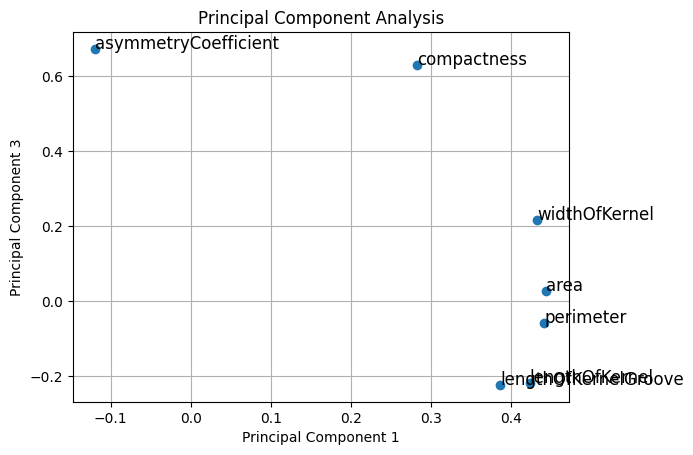

In [287]:
# Visualize the components
plt.scatter(components[0], components[2], marker='o')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 3')
plt.title('Principal Component Analysis')
plt.grid(True)

# Add labels for original features
for i, feature in enumerate(df2.columns):
    plt.annotate(feature, (components[0][i], components[2][i]), fontsize=12)

plt.show()

As what we did in EDA and previous steps, asymmestryCoefficient doesn't have strong relation with other attributes.

<Axes: >

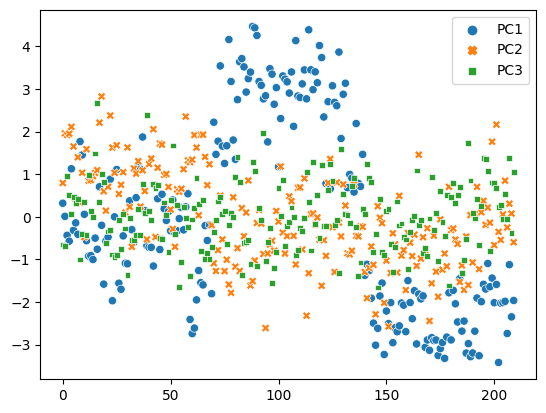

In [288]:
sns.scatterplot(data=pca_df)

Text(0, 0.5, 'Second Principle Component')

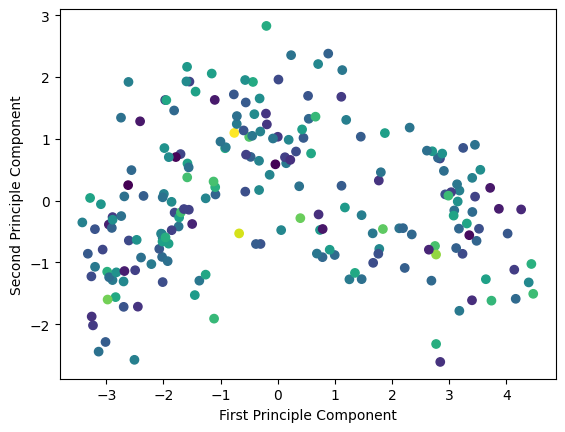

In [289]:
plt.scatter(pca_result[:,0], pca_result[:,1], c=pca_result[:,2])
plt.xlabel('First Principle Component')
plt.ylabel('Second Principle Component')

Text(0, 0.5, 'Third Principle Component')

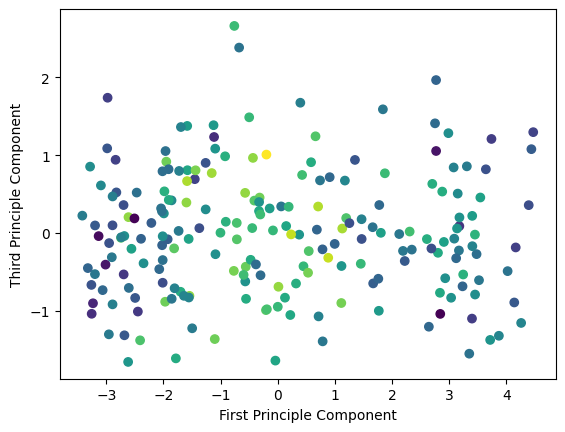

In [290]:
plt.scatter(pca_result[:,0], pca_result[:,2], c=pca_result[:,1])
plt.xlabel('First Principle Component')
plt.ylabel('Third Principle Component')

Well, it looks quite... messy .-. and they're not separable in 2 dimensions

In [291]:
np.corrcoef(pca_result)

array([[ 1.        ,  0.89627009,  0.21821789, ..., -0.59472858,
        -0.01305197, -0.69792197],
       [ 0.89627009,  1.        ,  0.6284023 , ..., -0.17648905,
         0.43177279, -0.3078973 ],
       [ 0.21821789,  0.6284023 ,  1.        , ...,  0.65477157,
         0.97296877,  0.54661501],
       ...,
       [-0.59472858, -0.17648905,  0.65477157, ...,  1.        ,
         0.81162046,  0.99082529],
       [-0.01305197,  0.43177279,  0.97296877, ...,  0.81162046,
         1.        ,  0.72522206],
       [-0.69792197, -0.3078973 ,  0.54661501, ...,  0.99082529,
         0.72522206,  1.        ]])

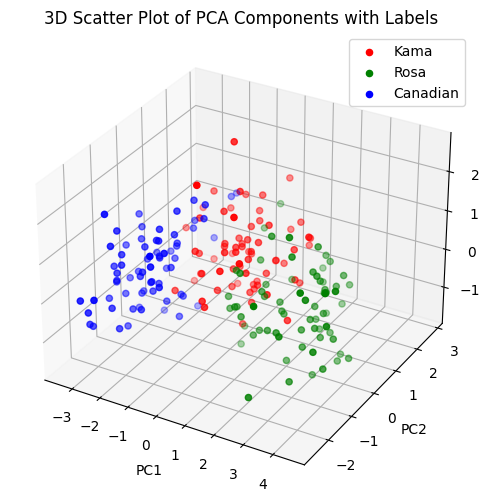

In [292]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Extract the three principal components
PC1 = pca_df['PC1']
PC2 = pca_df['PC2']
PC3 = pca_df['PC3']

# Scatter plot of the three principal components with labels seedType
for seedType, color in zip(df['seedType'].unique(), ['r', 'g', 'b']):
    mask = df['seedType'] == seedType
    ax.scatter(PC1[mask], PC2[mask], PC3[mask], c=color, marker='o', label=seedType)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D Scatter Plot of PCA Components with Labels')

plt.legend()
plt.show()